# 1. Importation

## Importation bibliothèques

In [1]:
# #montage disque google drive
from google.colab import drive
drive.mount('/content/drive/')
# Set working directory
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Projet 7/')
import timeit

Mounted at /content/drive/


In [2]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
from pandas.io.parsers.readers import read_csv

pd.set_option("display.max_rows", None, "display.max_columns", None)



# sklearn preprocessing for dealing with categorical variables less than 2 categories
from sklearn.preprocessing import LabelEncoder

# sklearn preprocessing for dealing with categorical variables less than 2 categories
from sklearn.preprocessing import OneHotEncoder

#Visualize Missing Data
import missingno

# graphiques
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# !pip install ipwidgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score 
from sklearn.metrics import recall_score, precision_score, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures 
# from sklearn.svm import SVC
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.tree import DecisionTreeClassifier
#Gradient Boosting Machine Modeling
import lightgbm as lgb
from lightgbm import LGBMClassifier
# Importation du package
from imblearn.over_sampling import SMOTE
from joblib import dump, load
import pickle

from sklearn import feature_selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFE, RFECV, SelectFromModel

from scipy.stats import pearsonr 

from matplotlib.pyplot import figure
# from google.colab import data_table
# data_table.enable_dataframe_formatter()

# %load_ext google.colab.data_table #To diable the display
# %unload_ext google.colab.data_table

# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)

In [31]:
models_results=pd.DataFrame(columns=['Model Type',#'threshold',
                                         'F1-Score','FBeta-Score','Recall_score', 'Precision_score','Roc_AUC_score'])

# 2. Fonctions utiles

## Modèles

### validation croisée

In [32]:
def gscv_modele(modele, parametres_modele):
    return GridSearchCV(estimator=modele,
                               param_grid=parametres_modele,
                               scoring=make_scorer(fbeta_score, beta = 2, pos_label=1 ,average = 'binary'),
                               cv=5, #Possibly value 
                               n_jobs=-1
                              )

### Choix des hyperparamètres des modèles

In [33]:
#logistic regression
lr = LogisticRegression(random_state=0)
lr_param={"C":np.logspace(0,10,5), "penalty":["l1","l2"]}
lr_cv = gscv_modele(lr, lr_param)

# #logistic regression
# svc = SVC(random_state=0)
# svc_param={"C":np.logspace(-1,3,5), 'gamma':np.logspace(-4,0,5), 'kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']}
# svc_cv = gscv_modele(svc, svc_param)


#decision tree classifier
dtc = DecisionTreeClassifier(random_state=0)
dtc_param = {'criterion':['gini','entropy'],'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,10,30]}
dtc_cv = gscv_modele(dtc, dtc_param)

#random forest classifier
rfc = RandomForestClassifier(random_state=0)
rfc_param = {'max_depth' : [4,10,30],'criterion' :['gini', 'entropy']}
rfc_cv = gscv_modele(rfc, rfc_param)

#gradient boosting classifier
gbc = GradientBoostingClassifier(random_state=0)
gbc_param= {'max_depth' : [2,3,4,5,6]}#{'max_depth' : np.linspace(2,6,5)}
gbc_cv = gscv_modele(gbc, gbc_param)

#light gradient boosting machine classifier
lgbmc = LGBMClassifier(random_state=0)
lgbmc_param = {'reg_alpha':np.linspace(0,1,5), 'reg_lambda': np.linspace(0,1,5)}
lgbmc_cv = gscv_modele(lgbmc, lgbmc_param)

### Matrice de confusion

In [34]:
#Fonction pour le graphe de Matrice de Confusion
def matrix_pred_model(model_name,yval,yval_pred):
    plt.figure(figsize=(5,5))
    plt.title("Matrice de confusion : " + model_name)
    sns.heatmap(confusion_matrix(yval,yval_pred),annot=True,fmt="d",cbar=False)
    plt.xlabel("Prédiction")
    plt.ylabel("Classe initial")
    #disp.plot()
    plt.savefig('./fig/confusion_matrix_'+model_name+'.png')
    plt.show()

### Courbe de ROC

In [35]:
#Fonction pour la courbe roc
def print_roc_curve(model_name, fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    plt.title("ROC Curve : "+ model_name)
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig('./fig/roc_'+model_name+'.png')
    plt.show()


### Sauvegarde

In [36]:
def save_model(model, model_name):
  # save the model to disk
  dump(model, './Models/'+model_name+'.joblib')
  filename = './Models/'+model_name+'.pkl'
  pickle.dump(model, open(filename, 'wb'))

### Fonction Evaluation

In [37]:
#Fonction pour retourner les score des modèles
def evaluation(model,model_name, Xval,yval, seuil=0.5):

    # On récupère la prédiction de la valeur positive
    yval_prob = model.predict_proba(Xval)[:,1]
    yval_pred = np.where(yval_prob > seuil, 1, 0) 
    # On créé un vecteur de prédiction à partir du vecteur de probabilités
    fpr, tpr, thresholds = roc_curve(yval, yval_prob)
    roc_auc = auc(fpr, tpr)
    matrix_pred_model(model_name, yval,yval_pred)  
    print_roc_curve(model_name, fpr, tpr)
    save_model(model, model_name)
    global models_results
    
    models_results=models_results.append({
        'Model Type': model_name,
        # 'seuil':seuil,
        'F1-Score':f1_score(yval, yval_pred),
        'FBeta-Score':fbeta_score(yval, yval_pred, average='binary', beta=2, pos_label=1),
        'Recall_score':recall_score(yval, yval_pred),
        'Precision_score':precision_score(yval, yval_pred),
        'Roc_AUC_score':auc(fpr, tpr)
        }, ignore_index=True)
    pd.DataFrame(models_results).to_csv('./Models/Models_results.csv',index=False)

In [38]:
def graphique_tableau_score(tableau):
  # # set plot style: grey grid in the background:
  # sns.set(style="darkgrid")

  # # load dataset
  # tips = sns.load_dataset("tips")

  # Set the figure size
  

  for col in tableau.columns:
    if col!="Model Type":
      # plt.figure(figsize=(20, 10))
      ax = sns.barplot(x=col, y="Model Type", data=tableau)
      plt.savefig('./fig/'+col+'.png')
      plt.show()

## Variables

### Choix variables

In [39]:
def choix_var_cat(dataframe_df):
  
  v_cat_bin=[]
  v_cat_sup=[]
  for col in dataframe_df.columns:
    if dataframe_df[col].nunique()<=2:
      v_cat_bin.append(col)
    else:
      v_cat_sup.append(col)
  return v_cat_bin, v_cat_sup

### Remplir données manquantes

In [40]:
def imputation_nan_knn(df_in, k):
  imputer = KNNImputer(n_neighbors=k)
  imputed = imputer.fit_transform(df_in)
  df_imputed = pd.DataFrame(imputed, columns=df_in.columns)
  return df_imputed

def imputation_nan_median(df_in):
  imputer = SimpleImputer(strategy = 'median')
  imputed = imputer.fit_transform(df_in)
  df_imputed = pd.DataFrame(imputed, columns=df_in.columns)
  return df_imputed

def imputation_nan_constant(df_in, value):
  imputer = SimpleImputer(strategy='constant', fill_value=value)
  imputed = imputer.fit_transform(df_in)
  df_imputed = pd.DataFrame(imputed, columns=df_in.columns)
  return df_imputed

### Variables categorielles

In [41]:
#suppression de colonnes nan
def trouve_colonne_nan(df):
    colonnes_nan=[]
    for col in df.columns:
        if col.find('_MISSING_VALUE')>-1:
            colonnes_nan.append(col)
    return colonnes_nan

#liste des colonnes supprimées
def suppression_colonnes(df, colonnes):
    print('Suppression de {0} colonnes:'.format(len(colonnes)))
#     print(colonnes)
    for col in colonnes:    
        print(" -"+ col)
    df.drop(axis=1, columns=colonnes, inplace=True)

### Variables numériques

In [42]:
def correlation_colonnes(df):
  corr_matrix=df.corr().abs()
  seuil=0.8
  upper=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
  to_drop=[col for col in upper.columns if any(upper[col]>seuil)]
  return to_drop

### Création de nouvelles variables

In [43]:
def creation_variables_fonctionnelles(dataframe_df):
  out_df=pd.DataFrame()
  #age du client
  out_df['CUSTOMER_AGE']=(dataframe_df['DAYS_BIRTH']/-365).astype(np.int)
  #pourcentage des rentes annuelles du credit sur les revenus du client
  out_df['AMT_ANNUITY_PER_INCOME'] = dataframe_df['AMT_ANNUITY'] / dataframe_df['AMT_INCOME_TOTAL']
  #durée des paiements en mois
  out_df['CREDIT_DURATION'] = (dataframe_df['AMT_CREDIT'] /dataframe_df['AMT_ANNUITY']*12).astype(np.int)
  #proportion de la période d’activité professionnelle du client par rapport à son age
  out_df['EMPLOYED_PER_AGE'] = dataframe_df['DAYS_EMPLOYED'] / dataframe_df['DAYS_BIRTH']*(-1)
  return out_df


In [44]:
def PolynomialFeatureNames(sklearn_feature_name_output, dataframe_df):
  import re
  cols = dataframe_df.columns.tolist()
  feat_map = {'x'+str(num):cat for num, cat in enumerate(cols)}
  feat_string = ','.join(sklearn_feature_name_output)
  for k,v in feat_map.items():
      feat_string = re.sub(fr"\b{k}\b",v,feat_string)
  return feat_string.replace(" "," x ").split(',')  

def create_polynomial_features(dataframe_df, columns_list):
  trans = PolynomialFeatures(degree=3)
  data=trans.fit_transform(dataframe_df[columns_list])
  total_columns_names=PolynomialFeatureNames(trans.get_feature_names(),dataframe_df[columns_list])
  out_data=pd.DataFrame(data, columns=total_columns_names)
  columns_to_delete=[i for i in range(trans.n_input_features_+1)]
  columns_to_delete_names=[total_columns_names[i] for i in columns_to_delete]
  out_data.drop(columns=columns_to_delete_names,axis=1, inplace=True)
  print('variables créées:\n')
  print(out_data.columns)
  return out_data

## Dataframe

### Définition des colonnes

In [45]:
def display_columns_description():
    pd.set_option('display.max_colwidth', None)
    Columns_description = pd.read_csv('./Data/HomeCredit_columns_description.csv',encoding='ISO-8859-1')
    alpha=Columns_description[Columns_description['Table']=='application_{train|test}.csv'][['Row','Description']]
    return alpha

### Reduction mémoire RAM

In [46]:
def reduce_mem_usage(dataframe):
  m_start = dataframe.memory_usage().sum() / 1024 ** 2
  for col in dataframe.columns:
    col_type = dataframe[col].dtype
    if col_type != object:
      c_min = dataframe[col].min()
      c_max = dataframe[col].max()
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          dataframe[col] = dataframe[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          dataframe[col] = dataframe[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          dataframe[col] = dataframe[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          dataframe[col] = dataframe[col].astype(np.int64)
      elif str(col_type)[:5] == 'float':
        if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
          dataframe[col] = dataframe[col].astype(np.float16)
        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          dataframe[col] = dataframe[col].astype(np.float32)
        else:
          dataframe[col] = dataframe[col].astype(np.float64)

  m_end = dataframe.memory_usage().sum() / 1024 ** 2
  print("L'usage mémoire de df est passée de {0}mo à {1}mo de RAM.".format(round(m_start,0),round(m_end,0)))
  return dataframe

# nan_as_category = True

### Passage colonnes en entier

In [47]:
def colonnes_int(dataframe_df):
  for col in dataframe_df.columns:
    if col in c_int:
      dataframe_df[col]=dataframe_df[col].astype(int)

### Equilibrage dataframe

In [48]:
def equilibrage(X, y):
  print('Avant smote :')
  print(y.value_counts())

  # Définition de l'instance SMOTE
  sm = SMOTE()#k_neighbors=3, sampling_strategy=0.75)

  # Application du SMOTE aux données
  X_smote, y_smote = sm.fit_resample(X, y)
  print('Après smote :')
  print(y_smote.value_counts())
  return X_smote, y_smote

### Standardiser dataframe

In [49]:
def standardiser_valeurs(dataframe_df):
  scaler = StandardScaler()
  dataframe_std = scaler.fit_transform(dataframe_df)
  dataframe_std_inv = scaler.inverse_transform(dataframe_std)
  return pd.DataFrame(data=dataframe_std_inv, columns=dataframe_df.columns)

### Normaliser dataframe

In [50]:
def normaliser_valeurs(dataframe_df):
  mmscaler = MinMaxScaler()
  dataframe_norm = mmscaler.fit_transform(dataframe_df)
  dataframe_norm_inv = mmscaler.inverse_transform(dataframe_norm)
  return pd.DataFrame(data=dataframe_norm_inv, columns=dataframe_df.columns)

### Traitements des outliers

In [51]:
# def imputation_outliers(data, feature):
  #   Q1 = data[feature].quantile(0.25)
  #   Q3 = data[col].quantile(0.75)
  #   IQR=Q3-Q1
  #   limite_haute=Q3 + 1.5 * IQR
  #   limite_basse=Q1 - 1.5 * IQR
  #   condition_1=data[col] < limite_basse
  #   condition_2=data[col] > limite_haute
  #   liste_col=data[condition_1|condition_2].index
  #   liste_outliers.extend(liste_col)
  # # liste=filtered_list(liste_outliers)
  # liste=list(set(liste_outliers))
  # return liste
  
def impute_outliers_feature(dataframe_df, feature):
  q1=np.percentile(dataframe_df[feature],25)
  q3=np.percentile(dataframe_df[feature],75)
  iqr=q3-q1
  lower_bound=q1-1.5*iqr
  upper_bound=q3+1.5*iqr
  dataframe_df.loc[dataframe_df[feature]<lower_bound, feature]=lower_bound
  dataframe_df.loc[dataframe_df[feature]>upper_bound, feature]=upper_bound  

def impute_outliers(dataframe_df):
  for feature in dataframe_df.columns:
    impute_outliers_feature(dataframe_df,feature)

### Variance_nulle

In [52]:
def variance_nulle(dataset):
  vt = VarianceThreshold() # Threshold default is 0
  vt.fit(dataset)
  var_vector_mask = vt.get_support()
  var_vector_mask 
  return dataset.loc[:, var_vector_mask]

### Graphiques variables

In [53]:
# analyse univariée
def plot_num_hist(a):
  sns.distplot(app_train[a], kde=False)
  plt.xlabel('asymetry: ' + str(round(app_train[a].skew(),3)))
  plt.title('Histogram of ' + str(a))
  return(plt.show())
def plot_num_box(a):
  sns.boxplot(y=app_train[a])
  # plt.xlabel('asymetry: ' + str(round(app_train[a].skew(),3)))
  plt.title('Boxplot of ' + str(a))
  return(plt.show())
def plot_cat(a):
  app_train[a].value_counts(normalize=True).plot(kind='bar')
  plt.ylabel('proportion')
  plt.title('Distribution of' + str(a))
  return(plt.show())

#analyse bivariée avec la TARGET
def boxplot_target(a):
  sns.boxplot(x='TARGET',y=a, data=app_train)
  # plt.xlabel('asymetry: ' + str(round(app_train[a].skew(),3)))
  plt.title('Boxplot of ' + str(a))
  return(plt.show())

def countplot_target(a):
  temp=app_train[a].nunique()
  plt.figure(figsize=(temp*4,temp*1))
  sns.countplot(x=a,data=app_train,hue="TARGET")
  plt.xticks(rotation=90)
  # plt.xlabel('asymetry: ' + str(round(app_train[a].skew(),3)))
  plt.title('Countplot of ' + str(a))
  return(plt.show())

# comparatif sans traitement standardisation et normalisation
def plot_num_std_norm(a):
  # sns.distplot(app_train[a], kde=False)
  fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(20,5))#figsize=(4,4))fig, axes = plt.subplots(2, 2)
  sns.regplot(x=X_preprocess["TARGET"], y=X_preprocess[a], ax=ax[0])
  sns.regplot(x=X_preprocess_std["TARGET"], y=X_preprocess_std[a], ax=ax[1])
  sns.regplot(x=X_preprocess_norm["TARGET"], y=X_preprocess_norm[a], ax=ax[2])

  plt.title('histograms of ' + str(a))
  return(plt.show())

# 3. Analyse exploratoire

## Généralités

In [ ]:
# Training data
app_train = pd.read_csv('./Data/application_train.csv')
print('App_train shape: ', app_train.shape)
print('App_train info: ', app_train.info(verbose=True))


App_train shape:  (307511, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH    

In [ ]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
app_train.nunique()

SK_ID_CURR                      307511
TARGET                               2
NAME_CONTRACT_TYPE                   2
CODE_GENDER                          3
FLAG_OWN_CAR                         2
FLAG_OWN_REALTY                      2
CNT_CHILDREN                        15
AMT_INCOME_TOTAL                  2548
AMT_CREDIT                        5603
AMT_ANNUITY                      13672
AMT_GOODS_PRICE                   1002
NAME_TYPE_SUITE                      7
NAME_INCOME_TYPE                     8
NAME_EDUCATION_TYPE                  5
NAME_FAMILY_STATUS                   6
NAME_HOUSING_TYPE                    6
REGION_POPULATION_RELATIVE          81
DAYS_BIRTH                       17460
DAYS_EMPLOYED                    12574
DAYS_REGISTRATION                15688
DAYS_ID_PUBLISH                   6168
OWN_CAR_AGE                         62
FLAG_MOBIL                           2
FLAG_EMP_PHONE                       2
FLAG_WORK_PHONE                      2
FLAG_CONT_MOBILE         

## Définition des colonnes

In [ ]:
display_columns_description()

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
5,FLAG_OWN_REALTY,Flag if client owns a house or flat
6,CNT_CHILDREN,Number of children the client has
7,AMT_INCOME_TOTAL,Income of the client
8,AMT_CREDIT,Credit amount of the loan
9,AMT_ANNUITY,Loan annuity


## Valeurs manquantes

In [ ]:
app_train.isna().mean().sort_values(ascending=False)

COMMONAREA_MEDI                 0.698723
COMMONAREA_AVG                  0.698723
COMMONAREA_MODE                 0.698723
NONLIVINGAPARTMENTS_MODE        0.694330
NONLIVINGAPARTMENTS_AVG         0.694330
NONLIVINGAPARTMENTS_MEDI        0.694330
FONDKAPREMONT_MODE              0.683862
LIVINGAPARTMENTS_MODE           0.683550
LIVINGAPARTMENTS_AVG            0.683550
LIVINGAPARTMENTS_MEDI           0.683550
FLOORSMIN_AVG                   0.678486
FLOORSMIN_MODE                  0.678486
FLOORSMIN_MEDI                  0.678486
YEARS_BUILD_MEDI                0.664978
YEARS_BUILD_MODE                0.664978
YEARS_BUILD_AVG                 0.664978
OWN_CAR_AGE                     0.659908
LANDAREA_MEDI                   0.593767
LANDAREA_MODE                   0.593767
LANDAREA_AVG                    0.593767
BASEMENTAREA_MEDI               0.585160
BASEMENTAREA_AVG                0.585160
BASEMENTAREA_MODE               0.585160
EXT_SOURCE_1                    0.563811
NONLIVINGAREA_MO

In [ ]:
app_train.select_dtypes(include=['float']).isna().mean().sort_values(ascending=False)

COMMONAREA_MODE                 0.698723
COMMONAREA_MEDI                 0.698723
COMMONAREA_AVG                  0.698723
NONLIVINGAPARTMENTS_MODE        0.694330
NONLIVINGAPARTMENTS_MEDI        0.694330
NONLIVINGAPARTMENTS_AVG         0.694330
LIVINGAPARTMENTS_MODE           0.683550
LIVINGAPARTMENTS_MEDI           0.683550
LIVINGAPARTMENTS_AVG            0.683550
FLOORSMIN_MEDI                  0.678486
FLOORSMIN_AVG                   0.678486
FLOORSMIN_MODE                  0.678486
YEARS_BUILD_AVG                 0.664978
YEARS_BUILD_MEDI                0.664978
YEARS_BUILD_MODE                0.664978
OWN_CAR_AGE                     0.659908
LANDAREA_AVG                    0.593767
LANDAREA_MODE                   0.593767
LANDAREA_MEDI                   0.593767
BASEMENTAREA_MEDI               0.585160
BASEMENTAREA_AVG                0.585160
BASEMENTAREA_MODE               0.585160
EXT_SOURCE_1                    0.563811
NONLIVINGAREA_MEDI              0.551792
NONLIVINGAREA_MO

In [ ]:
app_train.select_dtypes(include=['int']).isna().mean().sort_values(ascending=False)

SK_ID_CURR                     0.0
FLAG_DOCUMENT_2                0.0
FLAG_DOCUMENT_4                0.0
FLAG_DOCUMENT_5                0.0
FLAG_DOCUMENT_6                0.0
FLAG_DOCUMENT_7                0.0
FLAG_DOCUMENT_8                0.0
FLAG_DOCUMENT_9                0.0
FLAG_DOCUMENT_10               0.0
FLAG_DOCUMENT_11               0.0
FLAG_DOCUMENT_12               0.0
FLAG_DOCUMENT_13               0.0
FLAG_DOCUMENT_14               0.0
FLAG_DOCUMENT_15               0.0
FLAG_DOCUMENT_16               0.0
FLAG_DOCUMENT_17               0.0
FLAG_DOCUMENT_18               0.0
FLAG_DOCUMENT_19               0.0
FLAG_DOCUMENT_20               0.0
FLAG_DOCUMENT_3                0.0
LIVE_CITY_NOT_WORK_CITY        0.0
TARGET                         0.0
REG_CITY_NOT_WORK_CITY         0.0
CNT_CHILDREN                   0.0
DAYS_BIRTH                     0.0
DAYS_EMPLOYED                  0.0
DAYS_ID_PUBLISH                0.0
FLAG_MOBIL                     0.0
FLAG_EMP_PHONE      

In [ ]:
app_train.select_dtypes(include=['object']).isna().mean().sort_values(ascending=False)

FONDKAPREMONT_MODE            0.683862
WALLSMATERIAL_MODE            0.508408
HOUSETYPE_MODE                0.501761
EMERGENCYSTATE_MODE           0.473983
OCCUPATION_TYPE               0.313455
NAME_TYPE_SUITE               0.004201
NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
FLAG_OWN_REALTY               0.000000
NAME_INCOME_TYPE              0.000000
NAME_EDUCATION_TYPE           0.000000
NAME_FAMILY_STATUS            0.000000
NAME_HOUSING_TYPE             0.000000
WEEKDAY_APPR_PROCESS_START    0.000000
ORGANIZATION_TYPE             0.000000
dtype: float64

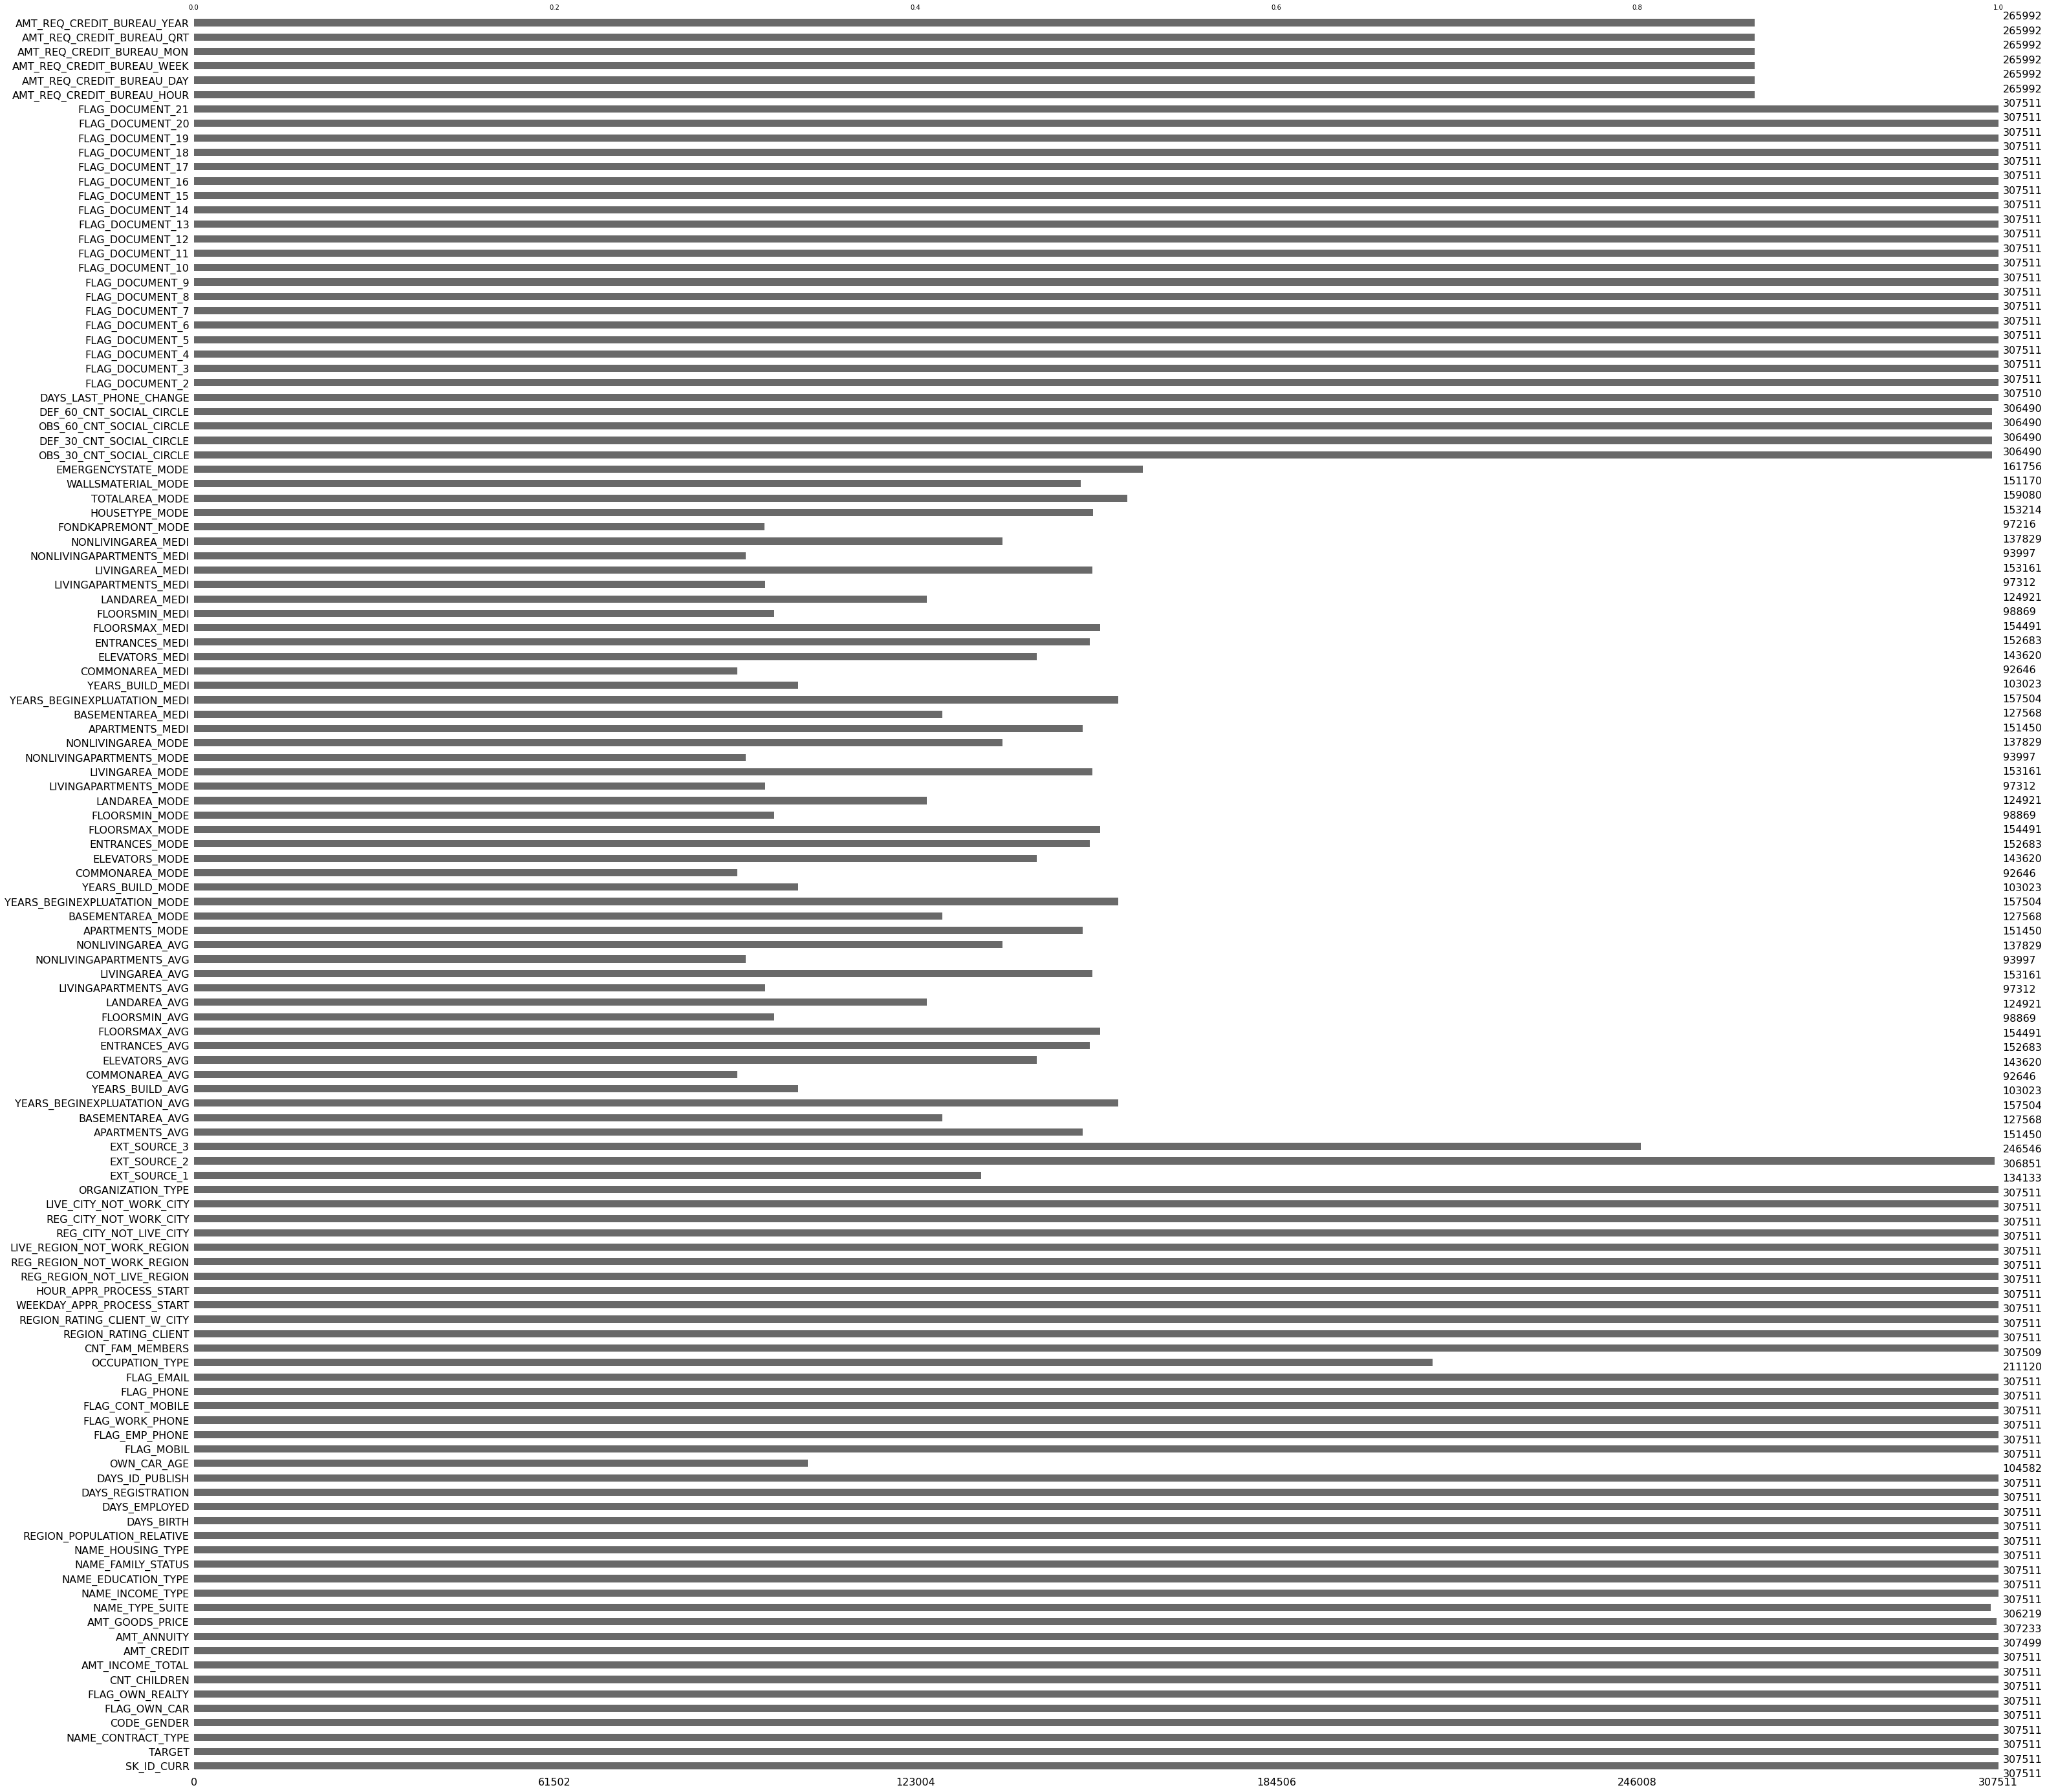

In [ ]:
missingno.bar(app_train, figsize=(50,50))

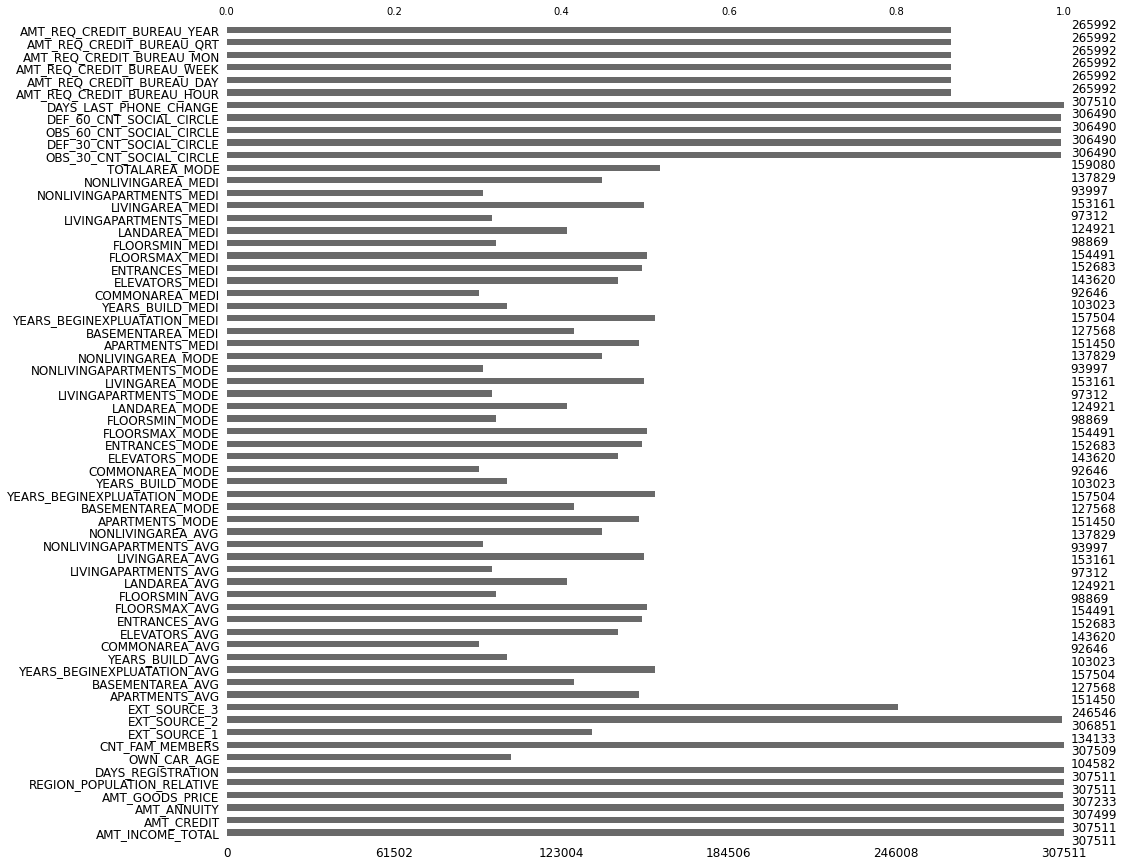

In [ ]:
missingno.bar(app_train.select_dtypes(include=['float']), figsize=(15,15), fontsize=12)
# app_train.select_dtypes(include=['object']).isna().mean().sort_values(ascending=False)

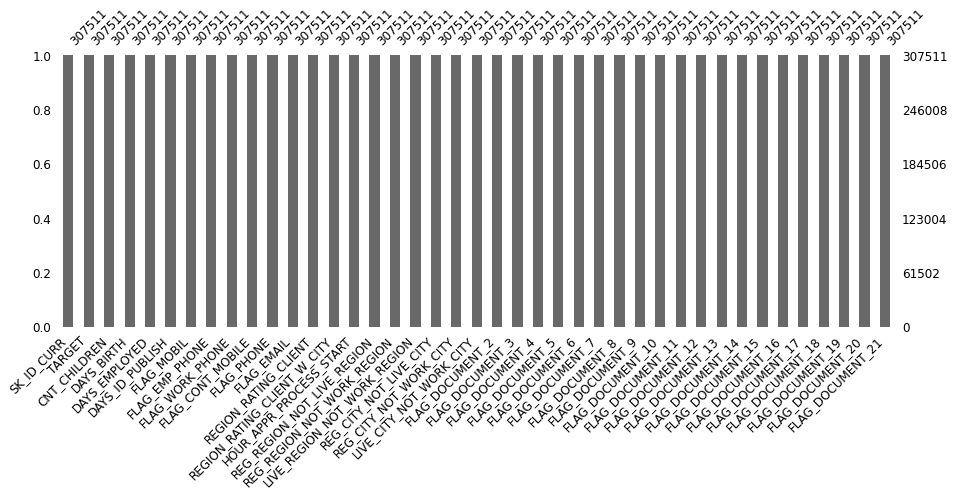

In [ ]:
missingno.bar(app_train.select_dtypes(include=['int']), figsize=(15,5), fontsize=12)

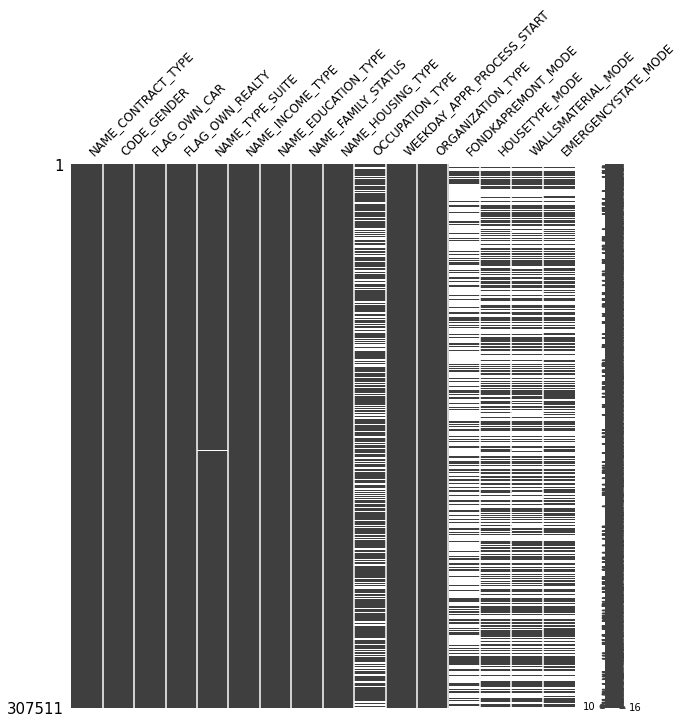

In [ ]:
missingno.matrix(app_train.select_dtypes(include=['object']),figsize=(10,10), fontsize=12)

## Valeurs uniques

In [ ]:
# Number of unique classes in each INT column
nunique_float = pd.DataFrame(app_train.select_dtypes(include=['float']).apply(pd.Series.nunique,axis=0),columns=["Nombre de valeur unique"])
nunique_float["valeur unique"] = app_train.select_dtypes(include=['float']).apply(pd.Series.unique,axis=0)
nunique_float.sort_values(by="Nombre de valeur unique", ascending=False)

,Nombre de valeur unique,valeur unique
EXT_SOURCE_2,119831,"[0.2629485927471776, 0.6222457752555098, 0.5559120833904428, 0.6504416904014653, 0.3227382869704046, 0.3542247319929012, 0.7239998516953141, 0.7142792864482229, 0.2057472880073281, 0.7466436294590924, 0.6518623334244781, 0.5551831615131809, 0.7150418188660659, 0.5669066132460429, 0.6426562048311103, 0.34663398139668, 0.2363778398884225, 0.6835133461914255, 0.7064284028871654, 0.5866171400119664, 0.113374512719927, 0.2337669575081463, 0.457142971588935, 0.6243047373592765, 0.7861793090532118, 0.6514056365297631, 0.5484771599678789, 0.5411237022695412, 0.6850109901296888, 0.5027790378786304, 0.479987342189869, 0.6273004007953609, 0.5594667916353414, 0.3217448956617718, 0.1724975081477771, 0.6631580756296298, 0.6816988025574287, 0.7197985370372056, 0.6507647995068742, 0.7380532835697358, 0.306840586048305, 0.0373152355612163, 0.6742032101473874, 0.7661378050275851, 0.6315186311742824, 0.535542260363498, 0.2476647173356162, 0.0892406534424171, 0.5891866296961207, 0.5239340474953537, 0.4508497225560816, 0.7133545848531052, 0.705947456699447, 0.7029791046049891, 0.6628649268152181, 0.6166372926426479, 0.6227082733555896, 0.6091352920795285, 0.2567370429595146, 0.6535972121081295, 0.5706663563799912, 0.0265407750366898, 0.7330511930996613, 0.6645439411246608, 0.5848873555356944, 0.6473478219828046, 0.5172704004425673, 0.5619229565929612, 0.1238882922844139, 0.6454384930609306, 0.6865047975453018, 0.7071263161734994, 0.5705270507243844, 0.3687189849837431, 0.5698732368655826, 0.5720641471414096, 0.5851740300889305, 0.5500579930157645, 0.4885999153777029, 0.5827354769124312, 0.3045061145430549, 0.0239523667712844, 0.3573422337147276, 0.5970811533321667, 0.6605789818593445, 0.495765140717496, 0.7162122102538987, 0.6611083077510267, 0.7180575365896832, 0.6446273721560554, 0.2547599571469118, 0.7566679797246073, 0.6405493008893001, 0.608604105963283, 0.4323402118056743, 0.5930185238421518, 0.1549370735653434, 0.3343001962973505, 0.7002735745029195, 0.6263029188866104, ...]"
EXT_SOURCE_1,114584,"[0.0830369673913225, 0.3112673113812225, nan, 0.7747614130547695, 0.5873340468730377, 0.3197601716755032, 0.7220444501416448, 0.4648311169632833, 0.7219397686622343, 0.1156343372622997, 0.5656548824667073, 0.4377090198475417, 0.5619484093041138, 0.6003959050009468, 0.2979135090150507, 0.2744223724911185, 0.8427634659543568, 0.8045861213121414, 0.4682080567974757, 0.7104273289168539, 0.6562248044601879, 0.3115099249880457, 0.2445616325354615, 0.1895957995501827, 0.5527719020519871, 0.2377197192577024, 0.2996061411205129, 0.2867830789116058, 0.7961611232881004, 0.202477374074608, 0.4115064104251909, 0.3577065472620613, 0.2707661633733818, 0.5927009939219194, 0.5866975916234531, 0.4476751393608083, 0.4147940693543055, 0.7631370618175837, 0.765153942091246, 0.5633231337420023, 0.4757617930038634, 0.3957242668511344, 0.6712718925800566, 0.2543516601822173, 0.4055643396822132, 0.4795441447548665, 0.3394026084270504, 0.7748801671358985, 0.5486469663609839, 0.3291857814541987, 0.8864868897220826, 0.6674963344753486, 0.5677754906901958, 0.3703423626276125, 0.6594043693464781, 0.6470448716896019, 0.6846964453639659, 0.6177157988717764, 0.0531827887508412, 0.1273929466752516, 0.8678716871178579, 0.5458589248298449, 0.3203218651732389, 0.5935670746654023, 0.6569383528999653, 0.5311064035337159, 0.7239404653083322, 0.5803669462489124, 0.3193565368929654, 0.7233712633792718, 0.6748315126672113, 0.7290899091709767, 0.4643561769338667, 0.7280918134588762, 0.5349985744410304, 0.7311052466018223, 0.4348784763127847, 0.3563551035088492, 0.5925473429253104, 0.7217605119102734, 0.7649171875783758, 0.3427122104865105, 0.5497171405900174, 0.6200196960355097, 0.5216328501389592, 0.667166655817305, 0.3800918342678742, 0.3941632655162739, 0.4129435398173111, 0.7410963179186301, 0.6215554079882224, 0.4372891777945847, 0.8530803639689652, 0.2449031137305613, 0.4050977259902663, 0.5824923923697667, 0.6364982706931857,

In [ ]:
# Number of unique classes in each INT column
nunique_int = pd.DataFrame(app_train.select_dtypes(include=['int']).apply(pd.Series.nunique,axis=0),columns=["Nombre de valeur unique"])
nunique_int["valeur unique"] = app_train.select_dtypes(include=['int']).apply(pd.Series.unique,axis=0)
nunique_int.sort_values(by="Nombre de valeur unique", ascending=False)

,Nombre de valeur unique,valeur unique
SK_ID_CURR,307511,"[100002, 100003, 100004, 100006, 100007, 100008, 100009, 100010, 100011, 100012, 100014, 100015, 100016, 100017, 100018, 100019, 100020, 100021, 100022, 100023, 100024, 100025, 100026, 100027, 100029, 100030, 100031, 100032, 100033, 100034, 100035, 100036, 100037, 100039, 100040, 100041, 100043, 100044, 100045, 100046, 100047, 100048, 100049, 100050, 100051, 100052, 100053, 100054, 100055, 100056, 100058, 100059, 100060, 100061, 100062, 100063, 100064, 100068, 100069, 100070, 100071, 100072, 100073, 100075, 100076, 100077, 100078, 100079, 100080, 100081, 100082, 100083, 100084, 100085, 100086, 100087, 100088, 100089, 100093, 100094, 100095, 100096, 100097, 100098, 100099, 100100, 100101, 100102, 100103, 100104, 100105, 100108, 100110, 100111, 100112, 100113, 100114, 100115, 100116, 100118, ...]"
DAYS_BIRTH,17460,"[-9461, -16765, -19046, -19005, -19932, -16941, -13778, -18850, -20099, -14469, -10197, -20417, -13439, -14086, -14583, -8728, -12931, -9776, -17718, -11348, -18252, -14815, -11146, -24827, -11286, -19334, -18724, -15948, -9994, -10341, -15280, -11144, -12974, -11694, -15997, -12158, -17199, -21077, -23920, -16126, -17482, -16971, -13384, -23548, -9827, -7974, -20373, -20121, -19727, -18264, -12406, -18632, -12282, -10473, -18611, -12955, -21621, -18248, -14186, -20544, -7907, -22843, -12240, -13866, -12049, -19550, -15359, -11956, -10848, -12009, -15406, -14860, -11187, -14264, -17542, -19467, -9666, -18253, -22935, -18693, -24794, -17527, -17390, -23032, -15909, -18138, -14321, -21112, -18556, -19810, -12780, -10744, -10485, -10199, -15137, -10734, -15371, -14751, -22471, -11142, ...]"
DAYS_EMPLOYED,12574,"[-637, -1188, -225, -3039, -3038, -1588, -3130, -449, 365243, -2019, -679, -2717, -3028, -203, -1157, -1317, -191, -7804, -2038, -4286, -1652, -4306, -746, -3494, -2628, -1234, -1796, -1010, -2668, -1104, -4404, -2060, -4585, -1275, -768, -1288, -1761, -1262, -475, -3597, -758, -895, -5332, -4411, -9523, -1176, -6977, -778, -1392, -4106, -2351, -1743, -2091, -2446, -1324, -3720, -2546, -579, -4856, -114, -3154, -121, -2844, -892, -1156, -2224, -2492, -2011, -4066, -2811, -721, -1434, -2442, -924, -1094, -969, -192, -1694, -862, -8862, -1415, -741, -1249, -2015, -7980, -693, -367, -6737, -2419, -2953, -669, -2469, -8466, -782, -267, -1169, -968, -1043, -465, -215, ...]"
DAYS_ID_PUBLISH,6168,"[-2120, -291, -2531, -2437, -3458, -477, -619, -2379, -3514, -3992, -738, -2512, -3227, -4911, -2056, -1368, -3866, -2427, -1259, -3964, -1800, -2299, -2518, -3684, -3729, -2893, -1827, -3153, -2661, -3015, -3787, -2904, -4464, -3557, -4067, -2009, -735, -4270, -4969, -4292, -1029, -513, -4409, -4576, -2380, -642, -1993, -3283, -3199, -1797, -2576, -1937, -1992, -1240, -2142, -5164, -1344, -1721, -4982, -566, -2177, -586, -3967, -4541, -4097, -1, -3084, -2922, -4143, -3494, -3656, -4176, -1072, -3723, -4517, -988, -2975, -2342, -1779, -3442, -2241, -4199, -983, -907, -793, -4180, -1681, -5942, -4013, -2045, -3043, -870, -2381, -3110, -1038, -1362, -4211, -4788, -4323, -467, ...]"
HOUR_APPR_PROCESS_START,24,"[10, 11, 9, 17, 16, 14, 8, 15, 7, 13, 6, 12, 19, 3, 18, 21, 4, 5, 20, 22, 1, 2, 23, 0]"
CNT_CHILDREN,15,"[0, 1, 2, 3, 4, 7, 5, 6, 8, 9, 11, 12, 10, 19, 14]"
REGION_RATING_CLIENT_W_CITY,3,"[2, 1, 3]"
REGION_RATING_CLIENT,3,"[2, 1, 3]"
FLAG_DOCUMENT_18,2,"[0, 1]"
FLAG_DOCUMENT_17,2,"[0, 1]"


In [ ]:
# Number of unique classes in each INT column
nunique_cat = pd.DataFrame(app_train.select_dtypes(include=['object']).apply(pd.Series.nunique,axis=0),columns=["Nombre de valeur unique"])
nunique_cat["valeur unique"] = app_train.select_dtypes(include=['object']).apply(pd.Series.unique,axis=0)
nunique_cat.sort_values(by="Nombre de valeur unique", ascending=False)

,Nombre de valeur unique,valeur unique
ORGANIZATION_TYPE,58,"[Business Entity Type 3, School, Government, Religion, Other, XNA, Electricity, Medicine, Business Entity Type 2, Self-employed, Transport: type 2, Construction, Housing, Kindergarten, Trade: type 7, Industry: type 11, Military, Services, Security Ministries, Transport: type 4, Industry: type 1, Emergency, Security, Trade: type 2, University, Transport: type 3, Police, Business Entity Type 1, Postal, Industry: type 4, Agriculture, Restaurant, Culture, Hotel, Industry: type 7, Trade: type 3, Industry: type 3, Bank, Industry: type 9, Insurance, Trade: type 6, Industry: type 2, Transport: type 1, Industry: type 12, Mobile, Trade: type 1, Industry: type 5, Industry: type 10, Legal Services, Advertising, Trade: type 5, Cleaning, Industry: type 13, Trade: type 4, Telecom, Industry: type 8, Realtor, Industry: type 6]"
OCCUPATION_TYPE,18,"[Laborers, Core staff, Accountants, Managers, nan, Drivers, Sales staff, Cleaning staff, Cooking staff, Private service staff, Medicine staff, Security staff, High skill tech staff, Waiters/barmen staff, Low-skill Laborers, Realty agents, Secretaries, IT staff, HR staff]"
NAME_INCOME_TYPE,8,"[Working, State servant, Commercial associate, Pensioner, Unemployed, Student, Businessman, Maternity leave]"
NAME_TYPE_SUITE,7,"[Unaccompanied, Family, Spouse, partner, Children, Other_A, nan, Other_B, Group of people]"
WEEKDAY_APPR_PROCESS_START,7,"[WEDNESDAY, MONDAY, THURSDAY, SUNDAY, SATURDAY, FRIDAY, TUESDAY]"
WALLSMATERIAL_MODE,7,"[Stone, brick, Block, nan, Panel, Mixed, Wooden, Others, Monolithic]"
NAME_FAMILY_STATUS,6,"[Single / not married, Married, Civil marriage, Widow, Separated, Unknown]"
NAME_HOUSING_TYPE,6,"[House / apartment, Rented apartment, With parents, Municipal apartment, Office apartment, Co-op apartment]"
NAME_EDUCATION_TYPE,5,"[Secondary / secondary special, Higher education, Incomplete higher, Lower secondary, Academic degree]"
FONDKAPREMONT_MODE,4,"[reg oper account, nan, org spec account, reg oper spec account, not specified]"


## Analyse univariée

### Variables numériques

In [ ]:
interact(plot_num_hist,a=list(app_train.select_dtypes(include=['float']).columns))
interact(plot_num_box,a=list(app_train.select_dtypes(include=['float']).columns))


interactive(children=(Dropdown(description='a', options=('AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT…

interactive(children=(Dropdown(description='a', options=('AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT…

<function __main__.plot_num_box>

In [ ]:
interact(plot_num_hist,a=list(app_train.select_dtypes(include=['int']).columns))
interact(plot_num_box,a=list(app_train.select_dtypes(include=['int']).columns))

interactive(children=(Dropdown(description='a', options=('SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'DAYS_BIRTH',…

interactive(children=(Dropdown(description='a', options=('SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'DAYS_BIRTH',…

<function __main__.plot_num_box>

### Variables catégorielles

In [ ]:
interact(plot_cat,a=list(app_train.select_dtypes(include=['object']).columns))

interactive(children=(Dropdown(description='a', options=('NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', …

<function __main__.plot_cat>

## Analyse bivariée

### Variables numériques avec la TARGET

In [ ]:
interact(boxplot_target,a=list(app_train.select_dtypes(include=['int','float']).columns))

interactive(children=(Dropdown(description='a', options=('SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_T…

<function __main__.boxplot_target>

### Variables catégorielles avec la TARGET

In [ ]:
interact(countplot_target,a=list(app_train.select_dtypes(include=['object']).columns))

interactive(children=(Dropdown(description='a', options=('NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', …

<function __main__.countplot_target>

# 4. Traitements

In [ ]:
df=app_train
df=reduce_mem_usage(df)

L'usage mémoire de df est passée de 286.0mo à 92.0mo de RAM.


## Séparation des variables par type

In [ ]:
c_float=list(df.select_dtypes(include=['float16','float32','float64']).columns)
v_float=df[c_float]
c_int=list(df.select_dtypes(include=['int8','int16','int32','int64']).columns)
v_int=df[c_int]
c_cat=list(df.select_dtypes(include=['object']).columns)
v_cat=df[c_cat]
c_num=[c_int,c_float]
v_num=pd.concat([v_int, v_float], axis=1)

## Variables catégorielles

### Traitement des valeurs manquantes



In [ ]:
v_cat=imputation_nan_constant(v_cat,'MISSING_VALUE')

### Séparation variables binaires et supérieur

In [ ]:
c_cat_bin=[]
c_cat_sup=[]
for col in c_cat:
  if v_cat[col].nunique()<3:
    c_cat_bin.append(col)
  else:
    c_cat_sup.append(col)
v_cat_bin=v_cat[c_cat_bin]
v_cat_sup=v_cat[c_cat_sup]

### Passage des variables catégorielles à 2 catégories en variables numériques par label encoder

In [ ]:
X_cat_bin=pd.DataFrame()
le = LabelEncoder()
X_cat_bin=v_cat_bin.apply(le.fit_transform)
X_cat_bin.columns

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'], dtype='object')

### Passage des variables catégorielles à plus de 2 catégories en variables numériques par one hot encoder

In [ ]:
ohe=OneHotEncoder(sparse=False)
X_cat_sup = pd.DataFrame(data=ohe.fit_transform(v_cat_sup), columns=ohe.get_feature_names_out())
# print(X_cat_sup.info())

colonnes_a_supprimer=trouve_colonne_nan(X_cat_sup)
suppression_colonnes(X_cat_sup, colonnes_a_supprimer)
print('Création de {0} colonnes numériques:'.format(len(X_cat_sup.columns)))
X_cat_sup.columns

Suppression de 6 colonnes:
 -NAME_TYPE_SUITE_MISSING_VALUE
 -OCCUPATION_TYPE_MISSING_VALUE
 -FONDKAPREMONT_MODE_MISSING_VALUE
 -HOUSETYPE_MODE_MISSING_VALUE
 -WALLSMATERIAL_MODE_MISSING_VALUE
 -EMERGENCYSTATE_MODE_MISSING_VALUE
Création de 134 colonnes numériques:


Index(['CODE_GENDER_F', 'CODE_GENDER_M', 'CODE_GENDER_XNA',
       'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family',
       'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A',
       'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner',
       'NAME_TYPE_SUITE_Unaccompanied',
       ...
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=134)

### Fusion des Dataframes catégorielles

In [ ]:
X_cat = pd.concat([X_cat_bin, X_cat_sup], axis=1)

## Variables numériques

### Suppression des variables à variance nulle

In [ ]:
not_null_var_columns=[]
for col in v_num.columns:
  if v_num[col].var()>0:
    not_null_var_columns.append(col)
print(len(not_null_var_columns))

88


In [ ]:
len(v_num.columns)

106

### Traitement des données aberrantes

In [ ]:
impute_outliers(v_num[not_null_var_columns])

### Suppression des variables fortement corrélées

In [ ]:
colonnes_a_supprimer=correlation_colonnes(v_num)
len(colonnes_a_supprimer)
suppression_colonnes(v_num, colonnes_a_supprimer)

Suppression de 40 colonnes:
 -FLAG_EMP_PHONE
 -REGION_RATING_CLIENT_W_CITY
 -LIVE_REGION_NOT_WORK_REGION
 -LIVE_CITY_NOT_WORK_CITY
 -AMT_GOODS_PRICE
 -CNT_FAM_MEMBERS
 -ELEVATORS_AVG
 -LIVINGAPARTMENTS_AVG
 -LIVINGAREA_AVG
 -APARTMENTS_MODE
 -BASEMENTAREA_MODE
 -YEARS_BEGINEXPLUATATION_MODE
 -YEARS_BUILD_MODE
 -COMMONAREA_MODE
 -ELEVATORS_MODE
 -ENTRANCES_MODE
 -FLOORSMAX_MODE
 -FLOORSMIN_MODE
 -LANDAREA_MODE
 -LIVINGAPARTMENTS_MODE
 -LIVINGAREA_MODE
 -NONLIVINGAPARTMENTS_MODE
 -NONLIVINGAREA_MODE
 -APARTMENTS_MEDI
 -BASEMENTAREA_MEDI
 -YEARS_BEGINEXPLUATATION_MEDI
 -YEARS_BUILD_MEDI
 -COMMONAREA_MEDI
 -ELEVATORS_MEDI
 -ENTRANCES_MEDI
 -FLOORSMAX_MEDI
 -FLOORSMIN_MEDI
 -LANDAREA_MEDI
 -LIVINGAPARTMENTS_MEDI
 -LIVINGAREA_MEDI
 -NONLIVINGAPARTMENTS_MEDI
 -NONLIVINGAREA_MEDI
 -TOTALAREA_MODE
 -OBS_60_CNT_SOCIAL_CIRCLE
 -DEF_60_CNT_SOCIAL_CIRCLE


### Traitement des données manquantes

In [ ]:
v_num=imputation_nan_median(v_num)

### Création des variables fonctionnelles

In [ ]:
v_fonc=creation_variables_fonctionnelles(v_num)

In [ ]:
seuil_pearson=0.8
for col in v_fonc.columns:
  coef = pearsonr(v_num["TARGET"], v_fonc[col]) 
  if abs(coef[0])>seuil_pearson:
    print(col)
  

### Création de variables polynomiales

In [ ]:
v_poly=create_polynomial_features(v_num,['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

variables créées:

Index(['EXT_SOURCE_1^2', 'EXT_SOURCE_1 x EXT_SOURCE_2',
       'EXT_SOURCE_1 x EXT_SOURCE_3', 'EXT_SOURCE_1 x DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 x EXT_SOURCE_3',
       'EXT_SOURCE_2 x DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 x DAYS_BIRTH', 'DAYS_BIRTH^2', 'EXT_SOURCE_1^3',
       'EXT_SOURCE_1^2 x EXT_SOURCE_2', 'EXT_SOURCE_1^2 x EXT_SOURCE_3',
       'EXT_SOURCE_1^2 x DAYS_BIRTH', 'EXT_SOURCE_1 x EXT_SOURCE_2^2',
       'EXT_SOURCE_1 x EXT_SOURCE_2 x EXT_SOURCE_3',
       'EXT_SOURCE_1 x EXT_SOURCE_2 x DAYS_BIRTH',
       'EXT_SOURCE_1 x EXT_SOURCE_3^2',
       'EXT_SOURCE_1 x EXT_SOURCE_3 x DAYS_BIRTH',
       'EXT_SOURCE_1 x DAYS_BIRTH^2', 'EXT_SOURCE_2^3',
       'EXT_SOURCE_2^2 x EXT_SOURCE_3', 'EXT_SOURCE_2^2 x DAYS_BIRTH',
       'EXT_SOURCE_2 x EXT_SOURCE_3^2',
       'EXT_SOURCE_2 x EXT_SOURCE_3 x DAYS_BIRTH',
       'EXT_SOURCE_2 x DAYS_BIRTH^2', 'EXT_SOURCE_3^3',
       'EXT_SOURCE_3^2 x DAYS_BIRTH', 'EXT_SOURCE_3 x DAYS_BIRTH^

In [ ]:
seuil_pearson=0.8
for col in v_poly.columns:
  coef = pearsonr(v_num["TARGET"], v_poly[col]) 
  if abs(coef[0])>seuil_pearson:
    print(col)
  

### Fusion des dataframes numériques en X_num

In [ ]:
v_num_fonc_poly=pd.concat([v_fonc, v_poly], axis=1)
X_num=pd.concat([v_num, v_num_fonc_poly], axis=1)

## Fusion des dataframes avec variables numériques

In [ ]:
X_preprocess = pd.concat([X_cat, X_num], axis=1)

## Standardisation du nouveau dataframe

In [ ]:
X_std=standardiser_valeurs(X_preprocess)

In [ ]:
X_std.info()

In [ ]:
# df_float.info(memory_usage = 'deep')
X_std=reduce_mem_usage(X_std)
X_std.to_csv('./Saved_data/standardised_application_train.csv', index=False)

## Normalisation du nouveau dataframe 

In [ ]:
X_norm=normaliser_valeurs(X_preprocess)

In [ ]:
# df_float.info(memory_usage = 'deep')
X_norm=reduce_mem_usage(X_norm)
X_norm.to_csv('./Saved_data/normalised_application_train.csv', index=False)

L'usage mémoire de df est passée de 556.0mo à 145.0mo de RAM.


# 5. Préparation pour choisir le modèle

## Séparation du dataframe en Train & Test

In [ ]:
seed=11111
#on normalise
df_temp=X_norm
y=df_temp["TARGET"]
# y=y.values.reshape(-1,1)
X=df_temp.drop("TARGET",axis=1)
#division 60% entrainement 20% validation et 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=seed, stratify=y_test)
print(X_train.shape)


(184506, 236)


## Reduction memoire

In [ ]:
y_train.head()

258528    0.0
210055    1.0
182522    0.0
266204    1.0
175149    0.0
Name: TARGET, dtype: float16

In [ ]:
X_train=reduce_mem_usage(X_train)
# y_train=reduce_mem_usage(y_train)
X_test=reduce_mem_usage(X_test)
# y_test=reduce_mem_usage(y_test)
X_val=reduce_mem_usage(X_val)
# y_val=reduce_mem_usage(y_val)

L'usage mémoire de df est passée de 88.0mo à 88.0mo de RAM.
L'usage mémoire de df est passée de 29.0mo à 29.0mo de RAM.
L'usage mémoire de df est passée de 29.0mo à 29.0mo de RAM.


## Equilibrage de la target

In [ ]:
X_train_smote, y_train_smote=equilibrage(X_train,y_train)

Avant smote :
0.0    169611
1.0     14895
Name: TARGET, dtype: int64
Après smote :
0.0    169611
1.0    169611
Name: TARGET, dtype: int64


## Sauvegarde

In [ ]:
X_train_smote['SK_ID_CURR']=X_train_smote['SK_ID_CURR'].astype(int)
X_test['SK_ID_CURR']=X_test['SK_ID_CURR'].astype(int)
X_val['SK_ID_CURR']=X_val['SK_ID_CURR'].astype(int)



In [ ]:
X_train_smote.to_csv('./Saved_data/X_train_smote.csv', index=False)
y_train_smote.to_csv('./Saved_data/y_train_smote.csv', index=False)
X_test.to_csv('./Saved_data/X_test.csv', index=False)
y_test.to_csv('./Saved_data/y_test.csv', index=False)
X_val.to_csv('./Saved_data/X_val.csv', index=False)
y_val.to_csv('./Saved_data/y_val.csv', index=False)

### Restaurer

In [ ]:
%%time
#lancement pour ganger du temps
X_train_smote = pd.read_csv('./Saved_data/X_train_smote.csv')
y_train_smote = pd.read_csv('./Saved_data/y_train_smote.csv')
X_test = pd.read_csv('./Saved_data/X_test.csv')
y_test = pd.read_csv('./Saved_data/y_test.csv')
X_val=pd.read_csv('./Saved_data/X_val.csv')
y_val=pd.read_csv('./Saved_data/y_val.csv')

CPU times: user 16.5 s, sys: 1.99 s, total: 18.4 s
Wall time: 28.1 s


In [ ]:
models_results=pd.read_csv('./Models/Models_results.csv')

In [ ]:
# models_results.drop(index=4,axis=0,inplace=True)

In [ ]:
models_results

,Model Type,F1-Score,FBeta-Score,Recall_score,Precision_score,Roc_AUC_score
0,logistic regression classifier,0.238670,0.324904,0.427996,0.165473,0.692672
1,decision tree classifier,0.141424,0.146706,0.150453,0.133417,0.558153
2,random forest classifier,0.010766,0.006780,0.005438,0.529412,0.713442
3,gradient boosting classifier,0.026985,0.017242,0.013897,0.463087,0.748888


# 6. Modèles

## Régression logistique

In [ ]:
#Train the gridSearchCV
lr_cv.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid={'C': array([1.00000000e+00, 3.16227766e+02, 1.00000000e+05, 3.16227766e+07,
       1.00000000e+10]),
                         'penalty': ['l1', 'l2']},
             scoring=make_scorer(fbeta_score, beta=2, pos_label=1, average=binary))

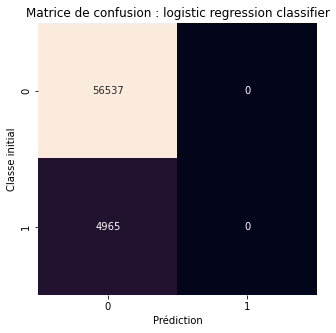

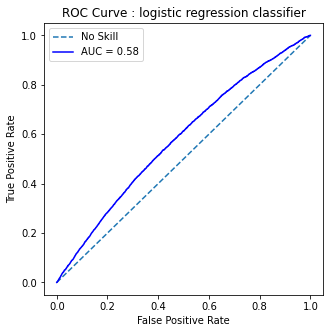

In [ ]:
#Train the classifier using best parameters identified during GridSearchCV
lr_hyperparam = LogisticRegression(**lr_cv.best_params_, random_state=0, class_weight='balanced')
lr_hyperparam.fit(X_train_smote,y_train_smote)

# seuil_lr=0.5
lr_name="logistic regression classifier"
evaluation(lr_hyperparam, lr_name,X_val, y_val)

In [ ]:
models_results

,Model Type,F1-Score,FBeta-Score,Recall_score,Precision_score,Roc_AUC_score
0,logistic regression classifier,0.0,0.0,0.0,0.0,0.578986


## Arbre de décision

In [ ]:
#Train the gridSearchCV
dtc_cv.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 10, 30],
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring=make_scorer(fbeta_score, beta=2, pos_label=1, average=binary))

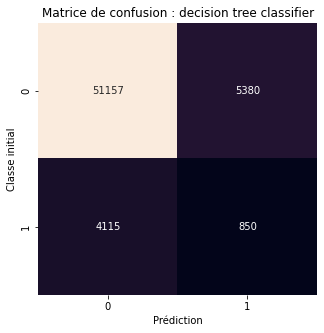

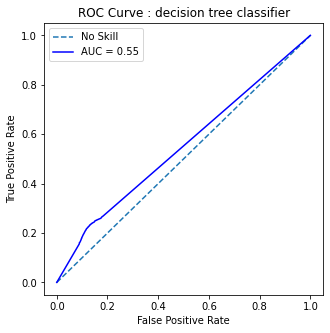

In [ ]:
#Train the classifier using best parameters identified during GridSearchCV
dtc_hyperparam = DecisionTreeClassifier(**dtc_cv.best_params_, random_state=0, class_weight='balanced')
dtc_hyperparam.fit(X_train_smote,y_train_smote)

# seuil_dtc=0.5
dtc_name="decision tree classifier"
evaluation(dtc_hyperparam, dtc_name,X_val, y_val)


## Forêt aléatoire

In [ ]:
#Train the gridSearchCV
rfc_cv.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 10, 30]},
             scoring=make_scorer(fbeta_score, beta=2, pos_label=1, average=binary))

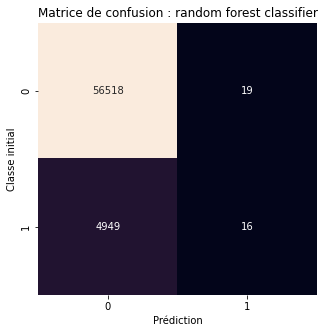

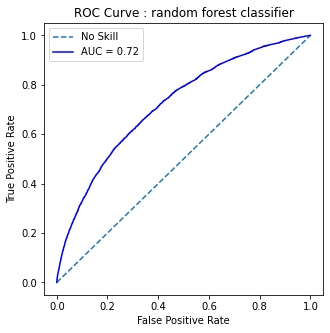

In [ ]:
#Train the classifier using best parameters identified during GridSearchCV
rfc_hyperparam = RandomForestClassifier(**rfc_cv.best_params_, random_state=0, class_weight='balanced')
rfc_hyperparam.fit(X_train_smote,y_train_smote)

# seuil_rfc=0.5
rfc_name="random forest classifier"
evaluation(rfc_hyperparam, rfc_name,X_val, y_val)

## Gradient boosting

In [ ]:
%%time
#Train the gridSearchCV
gbc_cv.fit(X_train_smote,y_train_smote)

CPU times: user 31min 32s, sys: 16 s, total: 31min 48s
Wall time: 5h 13min 30s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1, param_grid={'max_depth': [2, 3, 4, 5, 6]},
             scoring=make_scorer(fbeta_score, beta=2, pos_label=1, average=binary))

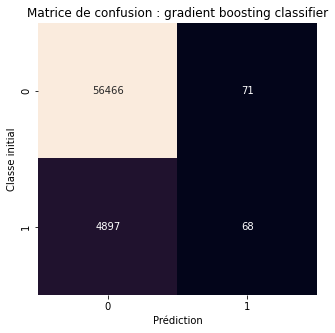

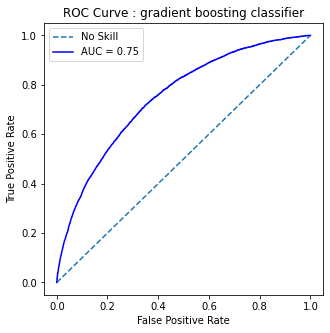

CPU times: user 29min 30s, sys: 2.04 s, total: 29min 32s
Wall time: 29min 23s


In [ ]:
%%time
#Train the classifier using best parameters identified during GridSearchCV
gbc_hyperparam = GradientBoostingClassifier(**gbc_cv.best_params_, random_state=0)
gbc_hyperparam.fit(X_train_smote,y_train_smote)

# seuil_gbc=0.5
gbc_name="gradient boosting classifier"
evaluation(gbc_hyperparam, gbc_name,X_val,y_val)

## LGBM

In [ ]:
%%time
#Train the gridSearchCV
lgbmc_cv.fit(X_train_smote,y_train_smote)

CPU times: user 1min 32s, sys: 7.28 s, total: 1min 39s
Wall time: 1h 1min 37s


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=0), n_jobs=-1,
             param_grid={'reg_alpha': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                         'reg_lambda': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
             scoring=make_scorer(fbeta_score, beta=2, pos_label=1, average=binary))

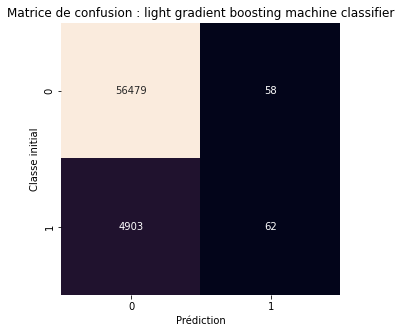

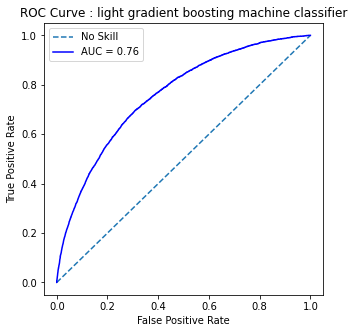

CPU times: user 1min 10s, sys: 453 ms, total: 1min 11s
Wall time: 38.7 s


In [ ]:
%%time
#Train the classifier using best parameters identified during GridSearchCV
#light gradient boosting machine classifier
lgbmc_hyperparam = LGBMClassifier(**lgbmc_cv.best_params_, random_state=0, class_weight='balanced')
lgbmc_hyperparam.fit(X_train_smote,y_train_smote)

# seuil_lgbmc=0.5
lgbmc_name="light gradient boosting machine classifier"
evaluation(lgbmc_hyperparam, lgbmc_name,X_val, y_val)

# 7. Résultats

In [ ]:
models_results

,Model Type,F1-Score,FBeta-Score,Recall_score,Precision_score,Roc_AUC_score
0,logistic regression classifier,0.000000,0.000000,0.000000,0.000000,0.578986
1,decision tree classifier,0.151854,0.162898,0.171198,0.136437,0.546818
2,random forest classifier,0.006400,0.004021,0.003223,0.457143,0.719823
3,gradient boosting classifier,0.026646,0.017001,0.013696,0.489209,0.748325
4,light gradient boosting machine classifier,0.024385,0.015516,0.012487,0.516667,0.758652


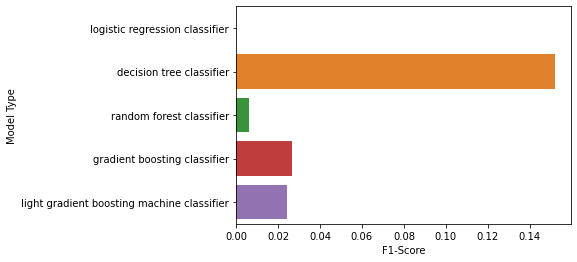

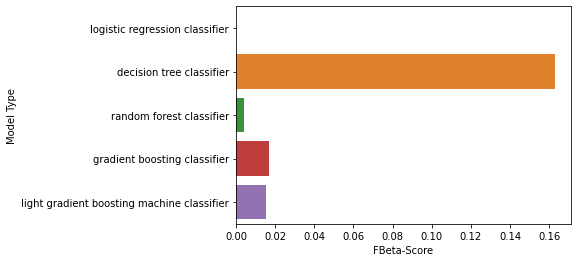

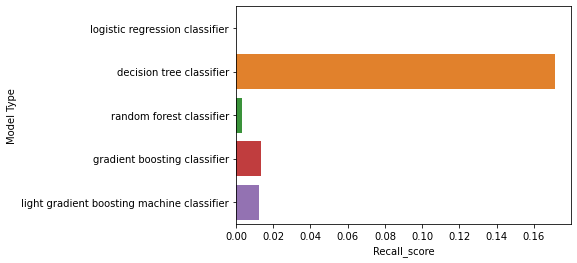

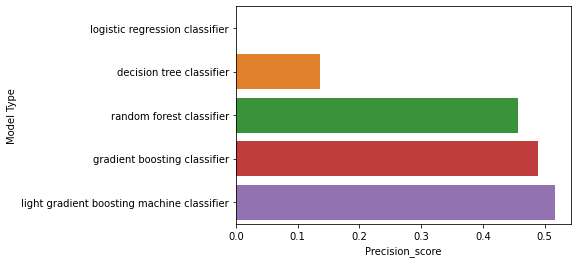

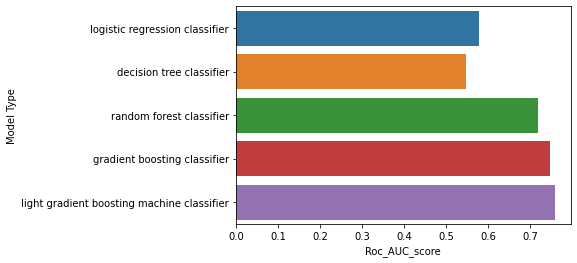

In [ ]:
graphique_tableau_score(models_results)

# 8. Meilleur modèle

## Variables importantes meilleur modele

In [ ]:
lgbmc_hyperparam_file = './Models/light gradient boosting machine classifier.sav'
lgbmc_hyperparam =  pickle.load(open(lgbmc_hyperparam_file, 'rb'))

In [ ]:
best_model=lgbmc_hyperparam 
best_model_name="light gradient boosting machine classifier"

In [ ]:
def tableau_coeff(model):
  model_coeff=model.feature_importances_
  model_var=X_test.columns
  model_best_coef=pd.concat((pd.DataFrame(model_var, columns = ['Variable']), 
                            pd.DataFrame(model_coeff, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient',ascending = False)
  return model_best_coef

def courbe_coeff(model_name,model_best_coeff):
  nb=len(model_best_coeff[model_best_coeff['Coefficient']!=0])
  plt.figure(figsize=(nb/3,nb/3))
  plt.title("Importance des " + str(nb) + " variables pour le modèle " + model_name)
  sns.barplot(data=model_best_coeff[model_best_coeff['Coefficient']!=0],x='Coefficient',y='Variable')
  plt.savefig("./fig/best_features_" + model_name +".png")
  return plt.show()

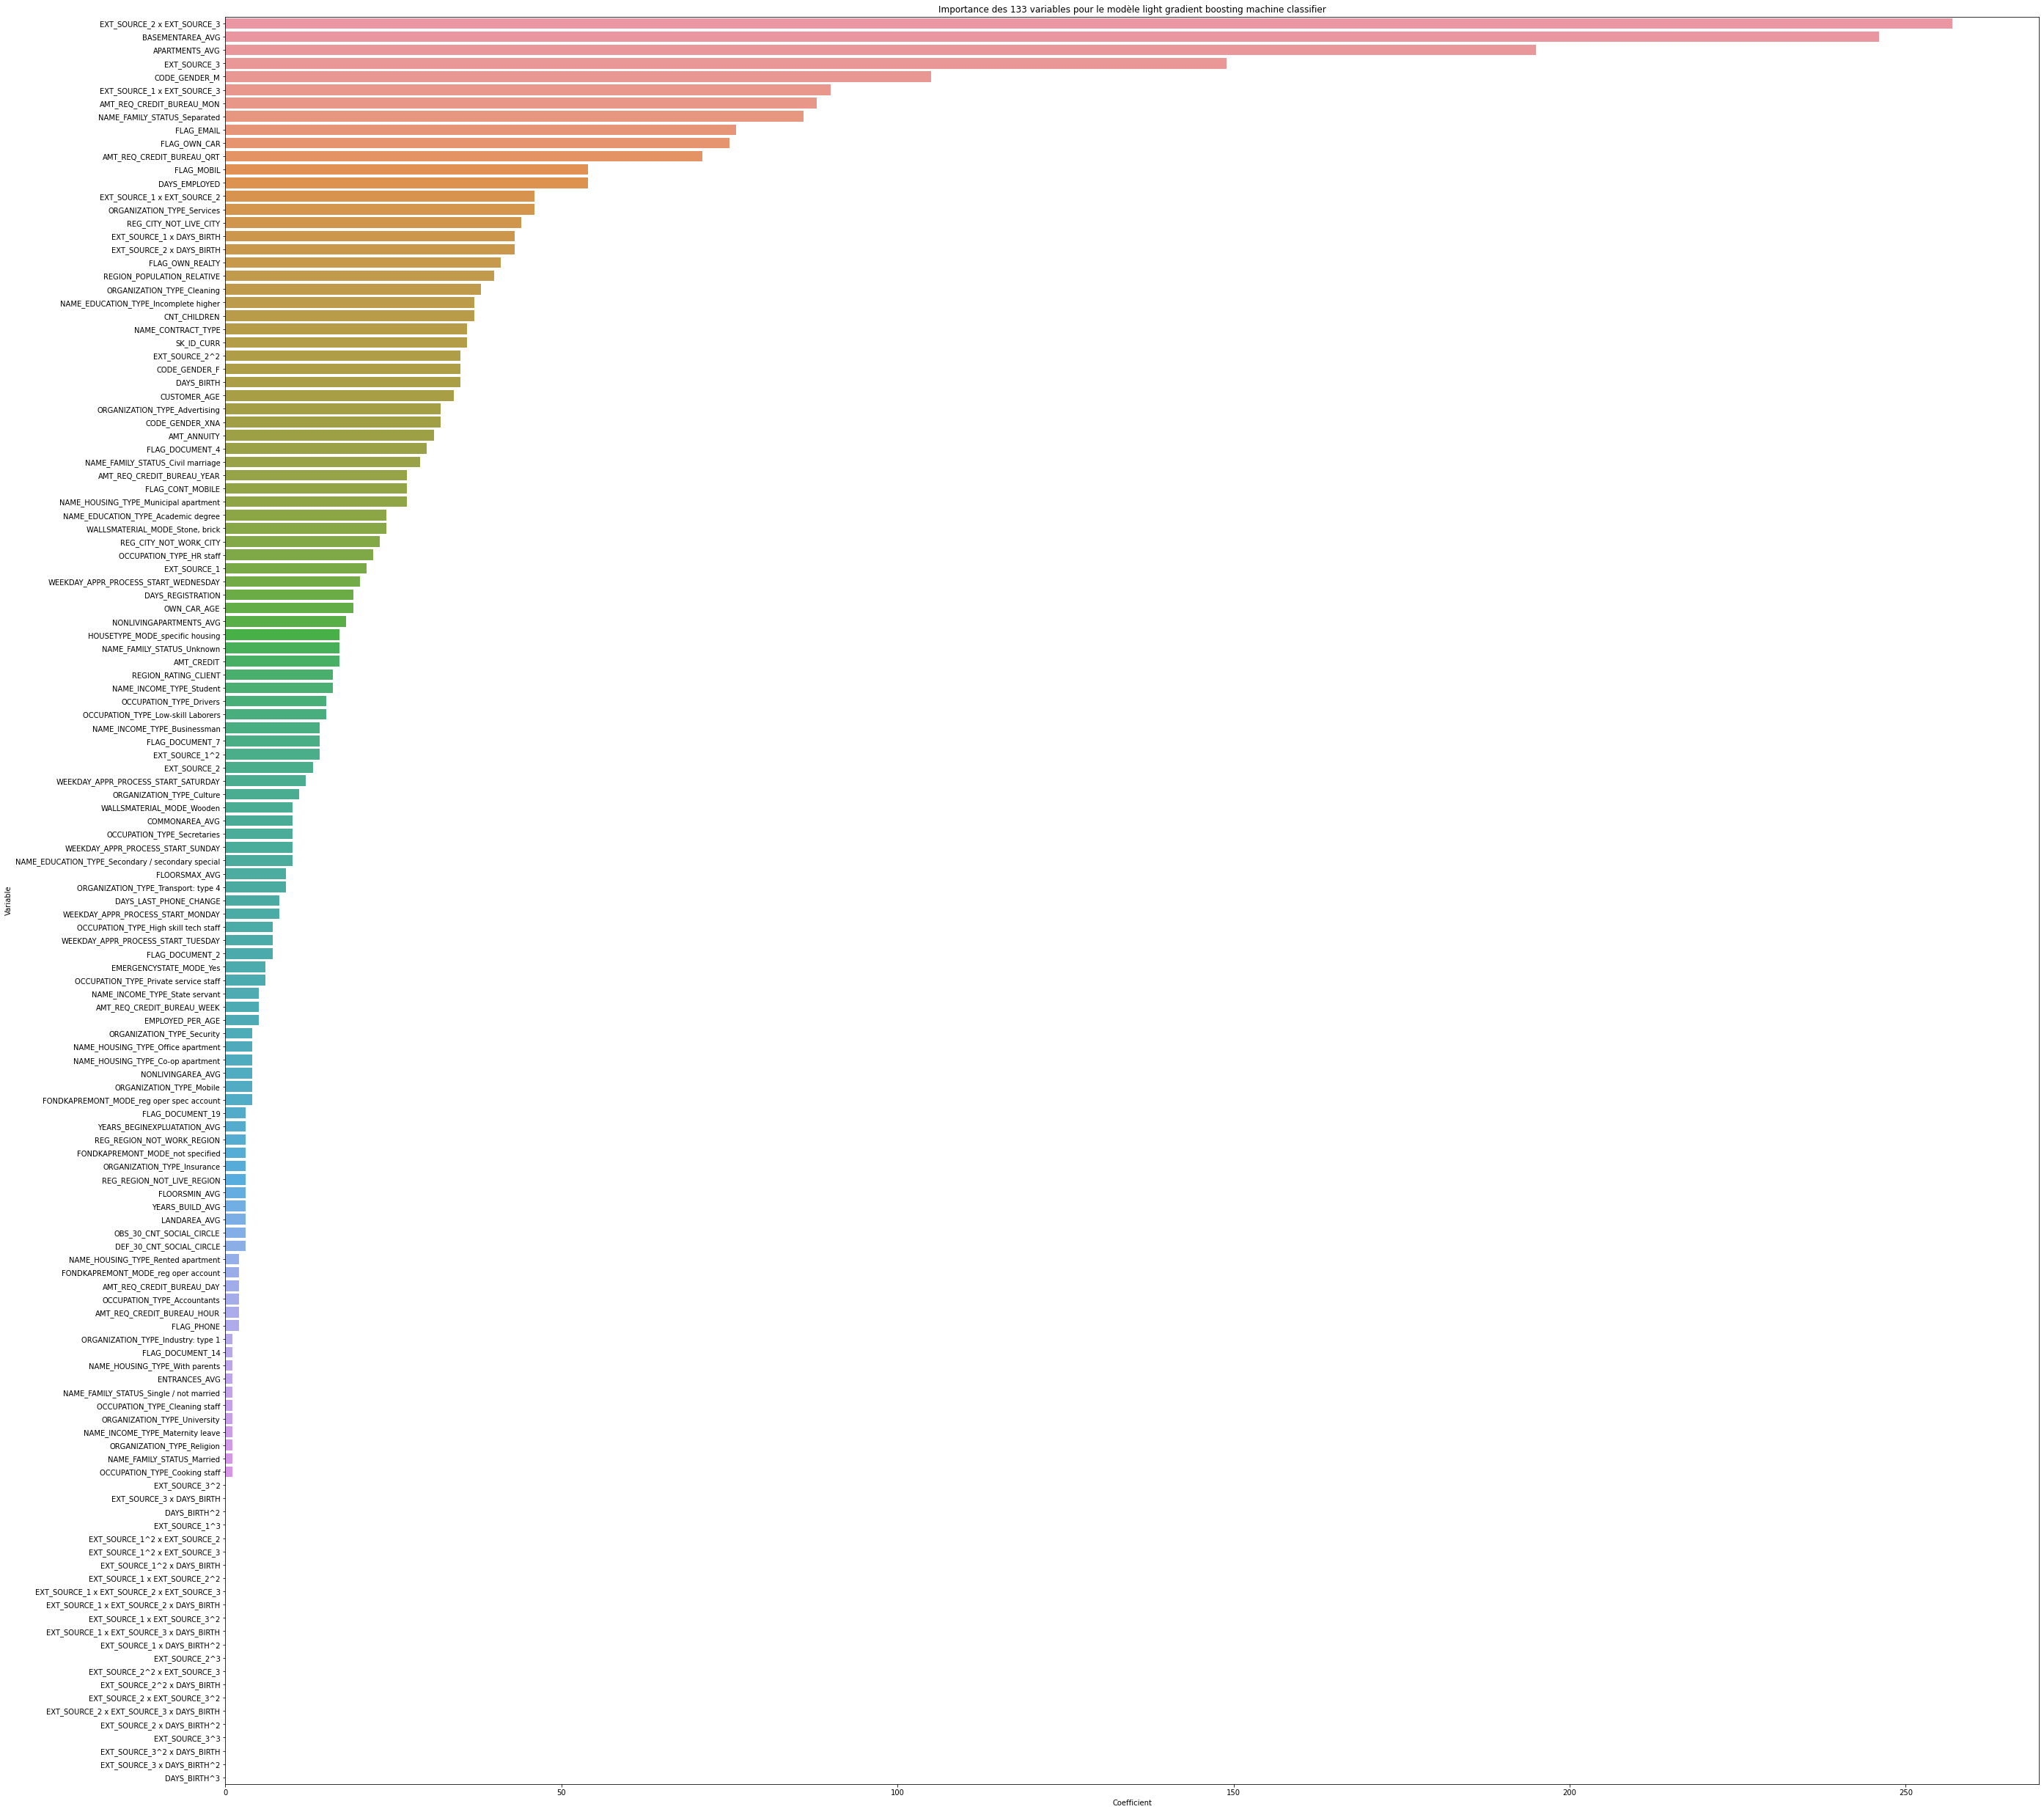

In [ ]:
best_coeff_best_model=tableau_coeff(best_model)
courbe_coeff(best_model_name,best_coeff_best_model)

## Reduction de variables pour le meilleur modele

In [ ]:
#RFE elimination de variables de façon récursive
def liste_variables_RFE(model,model_best_coeff):
  nb_var=len(model_best_coeff[model_best_coeff['Coefficient']!=0])
  RFE_model = RFE(estimator=model, verbose=0)#, n_features_to_select=nb_var, step=1)
  RFE_model.fit(X_train_smote, y_train_smote)
  mask=RFE_model.support_
  liste_variables=X_train_smote.loc[:,mask]
  return RFE_model,liste_variables.columns


In [ ]:
RFE_best_model, colonnes_RFE_best_model=liste_variables_RFE(best_model,best_coeff_best_model)

In [ ]:
colonnes_RFE_best_model

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CODE_GENDER_F', 'CODE_GENDER_M', 'NAME_TYPE_SUITE_Children',
       'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Unaccompanied',
       'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
       ...
       'EXT_SOURCE_1 x EXT_SOURCE_3 x DAYS_BIRTH',
       'EXT_SOURCE_1 x DAYS_BIRTH^2', 'EXT_SOURCE_2^3',
       'EXT_SOURCE_2^2 x EXT_SOURCE_3', 'EXT_SOURCE_2 x EXT_SOURCE_3^2',
       'EXT_SOURCE_2 x EXT_SOURCE_3 x DAYS_BIRTH', 'EXT_SOURCE_3^3',
       'EXT_SOURCE_3^2 x DAYS_BIRTH', 'EXT_SOURCE_3 x DAYS_BIRTH^2',
       'DAYS_BIRTH^3'],
      dtype='object', length=118)

In [ ]:
X_train_smote[colonnes_RFE_best_model].to_csv('./Saved_data/reduced_X_train_smote.csv', index=False)
X_val[colonnes_RFE_best_model].to_csv('./Saved_data/reduced_X_val.csv', index=False)
X_test[colonnes_RFE_best_model].to_csv('./Saved_data/reduced_X_test.csv', index=False)

In [54]:
# %%time
# #lancement pour ganger du temps
reduced_X_train_smote = pd.read_csv('./Saved_data/reduced_X_train_smote.csv')
reduced_X_test = pd.read_csv('./Saved_data/reduced_X_test.csv')
reduced_X_val=pd.read_csv('./Saved_data/reduced_X_val.csv')

In [55]:
reduced_X_train_smote['SK_ID_CURR']=reduced_X_train_smote['SK_ID_CURR'].astype(int)
reduced_X_test['SK_ID_CURR']=reduced_X_test['SK_ID_CURR'].astype(int)
reduced_X_val['SK_ID_CURR']=reduced_X_val['SK_ID_CURR'].astype(int)

In [ ]:
reduced_X_train_smote.to_csv('./Saved_data/reduced_X_train_smote.csv', index=False)
reduced_X_val.to_csv('./Saved_data/reduced_X_val.csv', index=False)
reduced_X_test.to_csv('./Saved_data/reduced_X_test.csv', index=False)

In [ ]:
RFE_best_model

RFE(estimator=LGBMClassifier(class_weight='balanced', random_state=0,
                             reg_alpha=0.25, reg_lambda=1.0))

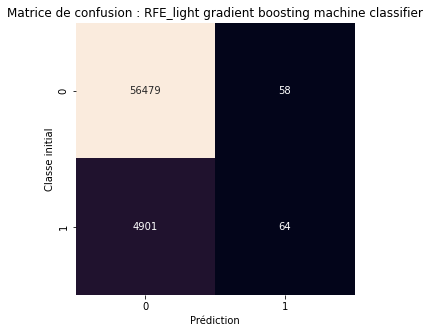

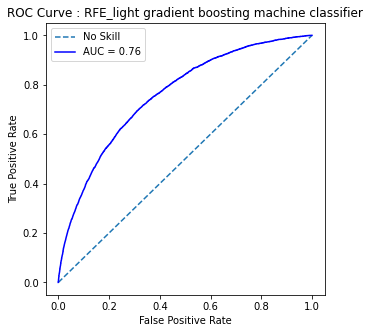

In [ ]:
lgbmc_cv.fit(X_train_smote[colonnes_RFE_best_model], y_train_smote)
RFE_lgbmc_hyperparam = LGBMClassifier(**lgbmc_cv.best_params_, random_state=0, class_weight='balanced')
RFE_lgbmc_hyperparam.fit(X_train_smote[colonnes_RFE_best_model],y_train_smote)

# seuil_lgbmc=0.5
RFE_lgbmc_name="RFE_light gradient boosting machine classifier"
evaluation(RFE_lgbmc_hyperparam, RFE_lgbmc_name,X_val[colonnes_RFE_best_model],y_val)#,seuil)

In [ ]:
models_results

,Model Type,F1-Score,FBeta-Score,Recall_score,Precision_score,Roc_AUC_score
0,logistic regression classifier,0.000000,0.000000,0.000000,0.000000,0.578986
1,decision tree classifier,0.151854,0.162898,0.171198,0.136437,0.546818
2,random forest classifier,0.006400,0.004021,0.003223,0.457143,0.719823
3,gradient boosting classifier,0.026646,0.017001,0.013696,0.489209,0.748325
4,light gradient boosting machine classifier,0.024385,0.015516,0.012487,0.516667,0.758652
5,RFE_light gradient boosting machine classifier,0.025162,0.016014,0.012890,0.524590,0.758708


## Choix du seuil

In [ ]:
thresholds_column_names = ["Model Name","seuil","beta","F1_score","FBeta-Score","Roc_AUC_score", "Recall_score", "Precision_score", "tn", "fp", "fn", "tp"]

def plot_threshold_scores():
    plt.plot(store_score_thresholds['seuil'], store_score_thresholds['FBeta-Score'], color='coral', lw=2, label='FBeta-Score')
    plt.plot(store_score_thresholds['seuil'], store_score_thresholds['Precision_score'], color='cyan', lw=2, label='Precision_score')
    plt.plot(store_score_thresholds['seuil'], store_score_thresholds['Recall_score'], color='green', lw=2, label='Recall_score')
    plt.plot(store_score_thresholds['seuil'], store_score_thresholds['F1_score'], color='red', lw=2, label='F1_score')
    #plt.plot(store_score_thresholds['seuil'], store_score_thresholds['Roc_AUC_score'], color='red', lw=2, label='Roc_AUC_score')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Seuil', fontsize=14)
    plt.ylabel('Scores', fontsize=14)
    plt.legend(loc="upper left")
    plt.title('Scores evolution with threshold')
    plt.show()

def predict_threshold(model,model_name,val_X_test,val_y_test, seuils, beta = 2):
    # On récupère la prédiction de la valeur positive
    y_prob = model.predict_proba(val_X_test)[:,1]
    # On créé un vecteur de prédiction à partir du vecteur de probabilités
    fpr, tpr, thr = roc_curve(val_y_test, y_prob)
    Roc_AUC_score = auc(fpr, tpr)
    #Roc_AUC_score = roc_auc_score(y_test, y_prob)
    for seuil in seuils: 
        y_pred = np.where(y_prob > seuil, 1, 0) #Set threshold value and get y_pred
        #y_pred = (y_prob >= seuil).astype(bool) # set threshold 
        #On recupere les valeurs de Negatif et Positifs
        tn, fp, fn, tp = confusion_matrix(val_y_test,y_pred).ravel()
        #On recupere les scores        
        F1_score = f1_score(val_y_test, y_pred)
        FBeta_score = fbeta_score(val_y_test, y_pred, average='binary', beta=beta, pos_label=1)
        Recall_score = recall_score(val_y_test, y_pred)
        Precision_score = precision_score(val_y_test, y_pred)      
        global store_score_thresholds
        score_results = pd.Series([model_name, seuil, beta, F1_score, FBeta_score, Roc_AUC_score, Recall_score, Precision_score, tn, fp, fn, tp])
        score_results_stored = pd.DataFrame([score_results.values],  columns = thresholds_column_names)
        store_score_thresholds = store_score_thresholds.append(score_results_stored, ignore_index=True)
    plot_threshold_scores()
    max_Fbeta = store_score_thresholds['FBeta-Score'].max()
    max_F1score = store_score_thresholds['F1_score'].max()
    optimized_seuil_Fbeta = store_score_thresholds.loc[(store_score_thresholds['FBeta-Score'] == max_Fbeta), 'seuil']
    optimized_seuil_F1score = store_score_thresholds.loc[(store_score_thresholds['F1_score'] == max_F1score), 'seuil']
    optimized_seuil =  optimized_seuil_Fbeta
    #print(f"The optimized threshold value is {optimized_seuil_Fbeta} estimated from the peak of the FBeta_Score curve {max_Fbeta}")
    #print(f"The optimized threshold value is {optimized_seuil_F1score} estimated from the peak of the FBeta_Score curve {max_F1score}")
    print(f"The optimized threshold is : {optimized_seuil}")
    # return(store_score_thresholds.sort_values(by=['FBeta-Score'], ascending=False).head(1))
#


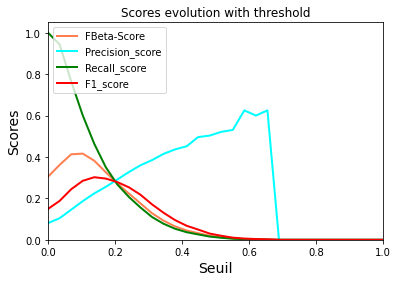

The optimized threshold is : 3    0.103448
Name: seuil, dtype: float64


In [ ]:
store_score_thresholds = pd.DataFrame(columns = thresholds_column_names)
seuils = np.linspace(0.0, 1.0, num = 30)
optimised_reduced_lgbmc_name="optimised reduced light gradient boosting machine classifier"
predict_threshold(RFE_lgbmc_hyperparam,
                  RFE_lgbmc_name,
                  X_val[colonnes_RFE_best_model],
                  y_val,
                  seuils)

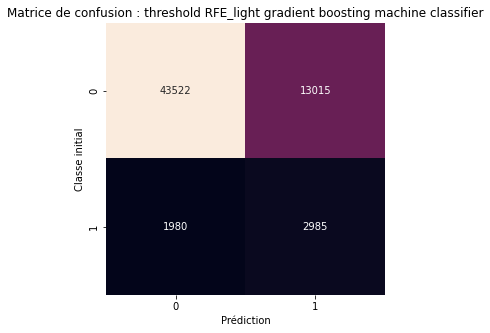

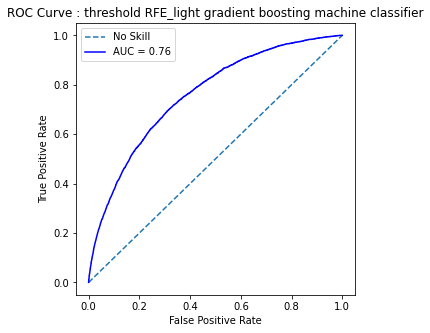

In [ ]:
#Compute the customized sample_weight
sample_weight = y_train_smote.shape[0]/(2*np.bincount(y_train_smote['TARGET']))
#Train the classifier using best parameters identified during GridSearchCV
# lgbmc_hyperparam = LGBMClassifier(**#lgbmc_cv.best_params_, random_state=0)
# reduced_lgbmc_hyperparam.fit(reduced_X_train_smote,y_train_smote, sample_weight = sample_weight[y_train_smote.values])

max_Fbeta = store_score_thresholds['FBeta-Score'].max()
seuil = store_score_thresholds.loc[(store_score_thresholds['FBeta-Score'] == max_Fbeta), ['seuil']].values[0]
#seuil = 0.37931
threshold_RFE_lgbmc_name="threshold " + RFE_lgbmc_name
evaluation(RFE_lgbmc_hyperparam,threshold_RFE_lgbmc_name,X_val[colonnes_RFE_best_model],y_val,seuil[0])

In [ ]:
models_results

,Model Type,F1-Score,FBeta-Score,Recall_score,Precision_score,Roc_AUC_score
0,logistic regression classifier,0.000000,0.000000,0.000000,0.000000,0.578986
1,decision tree classifier,0.151854,0.162898,0.171198,0.136437,0.546818
2,random forest classifier,0.006400,0.004021,0.003223,0.457143,0.719823
3,gradient boosting classifier,0.026646,0.017001,0.013696,0.489209,0.748325
4,light gradient boosting machine classifier,0.024385,0.015516,0.012487,0.516667,0.758652
5,RFE_light gradient boosting machine classifier,0.025162,0.016014,0.012890,0.524590,0.758708
6,threshold RFE_light gradient boosting machine ...,0.284760,0.416202,0.601208,0.186562,0.758708


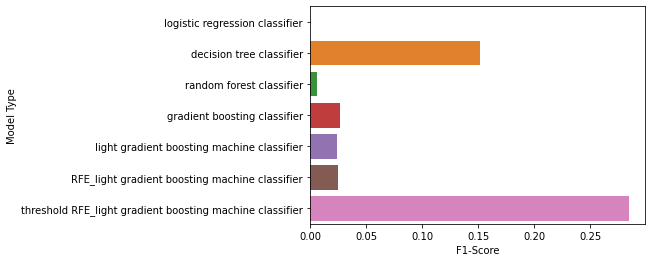

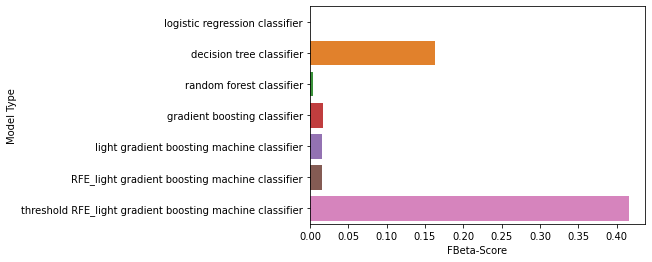

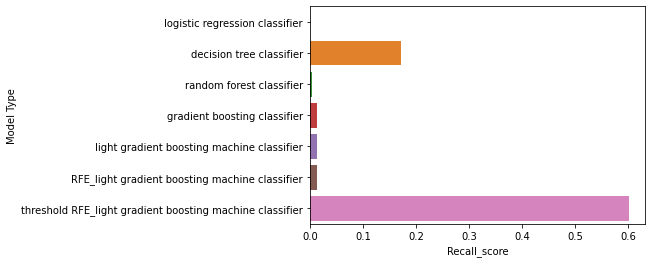

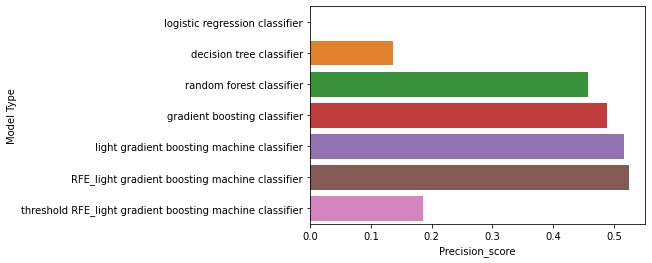

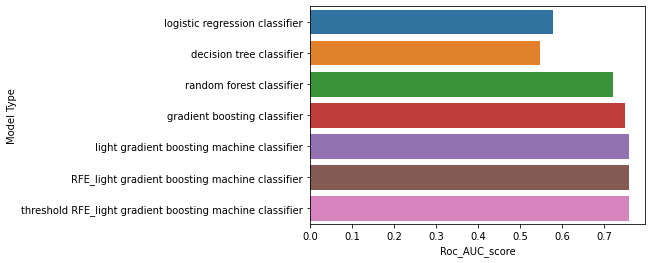

In [ ]:
graphique_tableau_score(models_results)

In [56]:
reduced_X_test.set_index("SK_ID_CURR", inplace = True)
reduced_X_test.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Transport: type 3,FONDKAPREMONT_MODE_reg oper account,HOUSETYPE_MODE_block of flats,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",EMERGENCYSTATE_MODE_No,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_18,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAPARTMENTS_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_ANNUITY_PER_INCOME,CREDIT_DURATION,EMPLOYED_PER_AGE,EXT_SOURCE_1^2,EXT_SOURCE_1 x EXT_SOURCE_2,EXT_SOURCE_1 x EXT_SOURCE_3,EXT_SOURCE_1 x DAYS_BIRTH,EXT_SOURCE_2 x EXT_SOURCE_3,EXT_SOURCE_2 x DAYS_BIRTH,EXT_SOURCE_3^2,EXT_SOURCE_3 x DAYS_BIRTH,DAYS_BIRTH^2,EXT_SOURCE_1^3,EXT_SOURCE_1^2 x EXT_SOURCE_2,EXT_SOURCE_1^2 x EXT_SOURCE_3,EXT_SOURCE_1^2 x DAYS_BIRTH,EXT_SOURCE_1 x EXT_SOURCE_2^2,EXT_SOURCE_1 x EXT_SOURCE_2 x EXT_SOURCE_3,EXT_SOURCE_1 x EXT_SOURCE_2 x DAYS_BIRTH,EXT_SOURCE_1 x EXT_SOURCE_3^2,EXT_SOURCE_1 x EXT_SOURCE_3 x DAYS_BIRTH,EXT_SOURCE_1 x DAYS_BIRTH^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 x EXT_SOURCE_3,EXT_SOURCE_2 x EXT_SOURCE_3^2,EXT_SOURCE_2 x EXT_SOURCE_3 x DAYS_BIRTH,EXT_SOURCE_3^3,EXT_SOURCE_3^2 x DAYS_BIRTH,EXT_SOURCE_3 x DAYS_BIRTH^2,DAYS_BIRTH^3
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
132816,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-17040.0,-1120.0,-115.0,1.0,0.0,2.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,135000.0,971280.0,54364.5,0.009180,-3748.0,6.0,0.506,0.7397,0.5350,0.2320,0.0832,0.9795,0.7210,0.0149,0.0345,0.3333,0.3750,0.1993,0.0232,1.0,0.0,-931.0,0.0,0.0,0.0,1.0,0.40260,214.0,-0.06573,0.2559,0.37430,0.2708,-8620.0,0.39600,-12610.0,0.28640,-9120.0,290532030.0,0.1294,0.18930,0.13700,-4360.0,0.276900,0.20030,-6380.0,0.14490,-4616.0,146968350.0,0.404800,0.29300,0.21190,-6748.0,0.153300,-4880.0,155480030.0,-4.952118e+12
186487,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,-10424.0,-1188.0,-1516.0,0.0,0.0,3.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1

In [57]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans

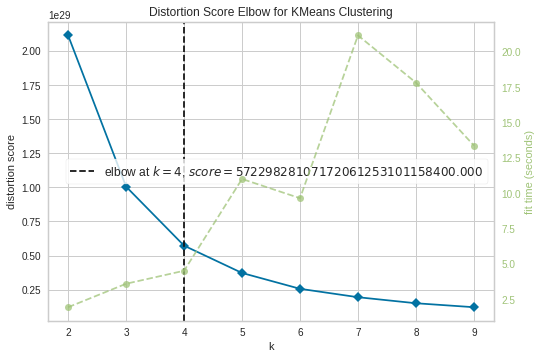

In [58]:
model_km = KMeans()
visualizer1 = KElbowVisualizer(model_km, k=(2,10))
visualizer1.fit(reduced_X_test)
visualizer1.poof()

In [59]:
clf_km=KMeans(n_clusters=4).fit(reduced_X_test)

In [61]:
save_model(model_km, 'clustering')